# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 9.8 MB/s eta 0:00:00


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    DivisiblePadd,
    SqueezeDimd,
    Resized,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, VNet, SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, PatchIterd, GridPatchDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpgoik7kbm


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:35, 45.4MB/s]                            

2023-01-16 19:24:21,746 - INFO - Downloaded: /tmp/tmpbd6fwkg5/Task09_Spleen.tar


2023-01-16 19:24:24,941 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-01-16 19:24:24,942 - INFO - Writing into directory: /tmp/tmpbd6fwkg5.


## Set MSD Spleen dataset path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1='/content/drive/My Drive/Dataset/DATA/ADC'
file_path2='/content/drive/My Drive/Dataset/DATA/Label/thigh'

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(file_path1, "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(file_path2, "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-6], data_dicts[-6:]

In [ ]:
print(val_files)

[{'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM77PS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM77PS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM78BP.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM78BP.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM81LS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM81LS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM85GN.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM85GN.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM90AE.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM90AE.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/ADC/MM93AC.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM93AC.nii.gz'}]


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [ ]:
import numpy as np

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 5), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        DivisiblePadd(["image", "label"], 16),
        # user can also add other random transforms

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 5), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        DivisiblePadd(["image", "label"], 16),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([288, 96, 240]), label shape: torch.Size([288, 96, 240])


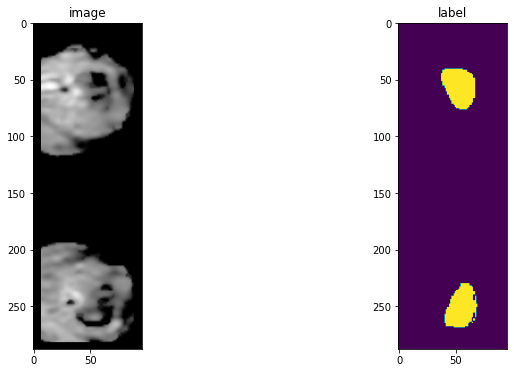

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 60], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Loading dataset: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


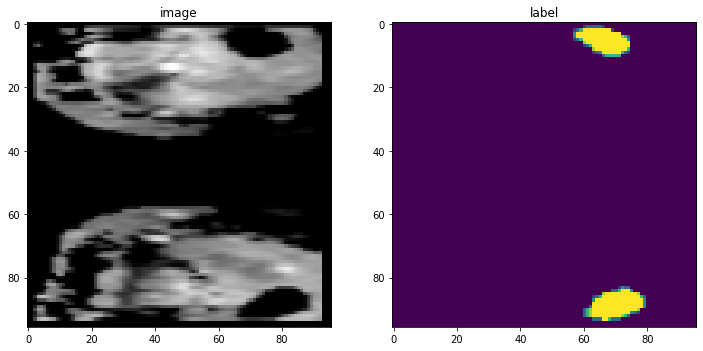

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
patch_func = PatchIterd(
    keys=["image", "label"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[96, 96]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_train_ds = GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
patch_val_ds = GridPatchDataset(
    data=val_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_loader = DataLoader(
    patch_train_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    patch_val_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)
plt.show()

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


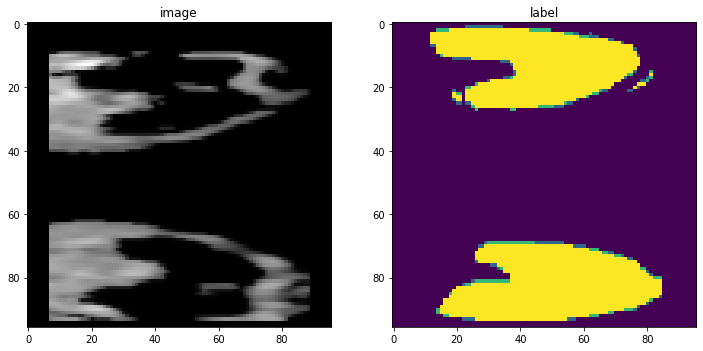

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


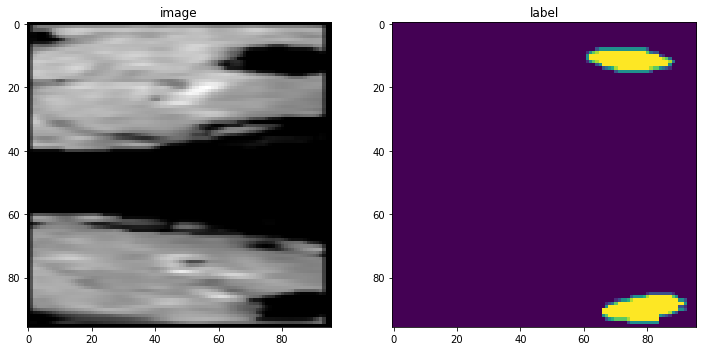

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


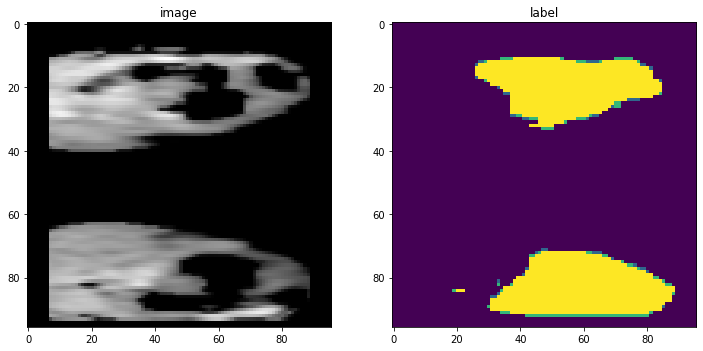

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


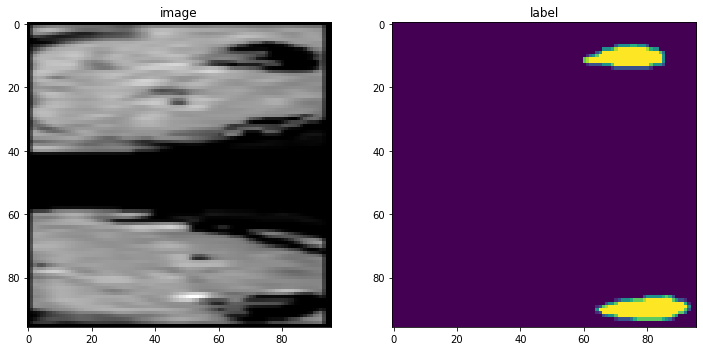

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


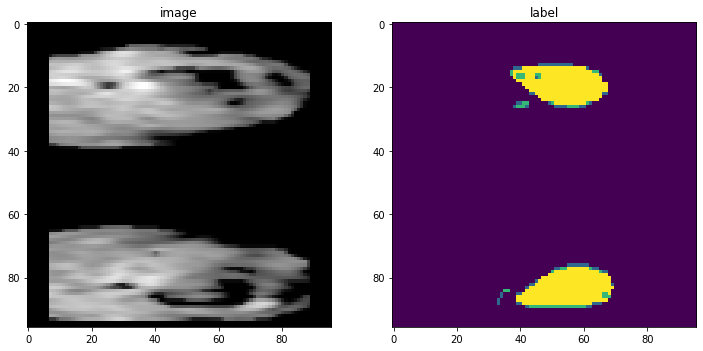

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


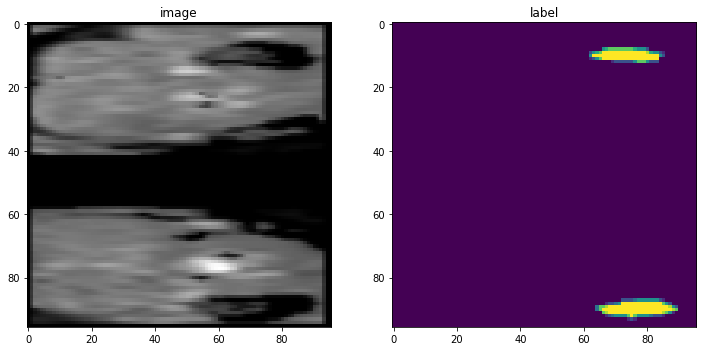

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


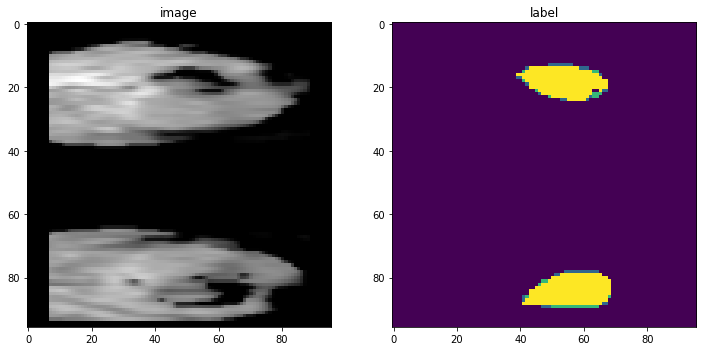

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


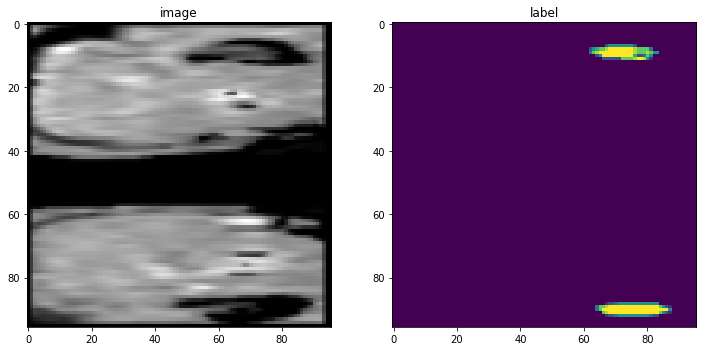

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


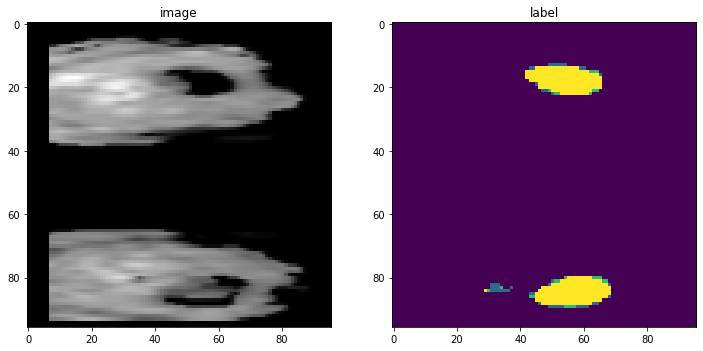

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


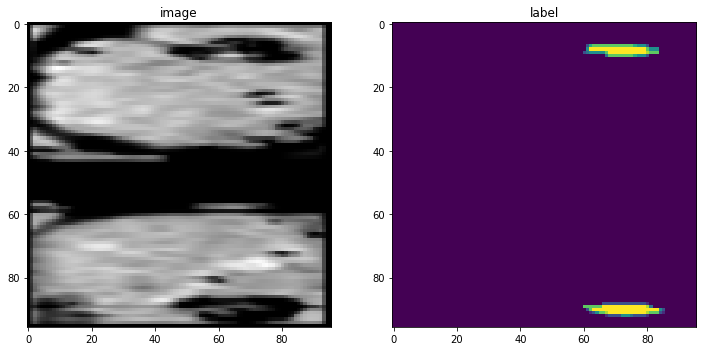

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


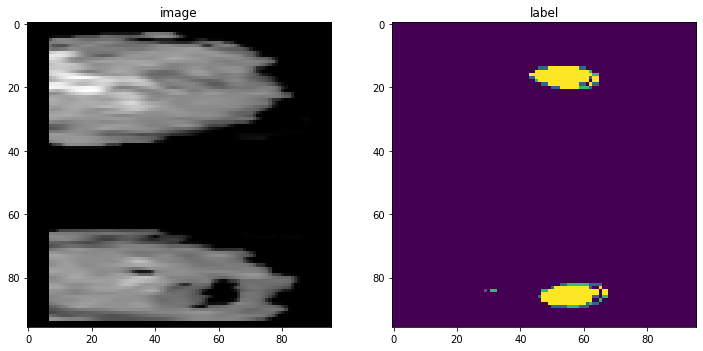

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


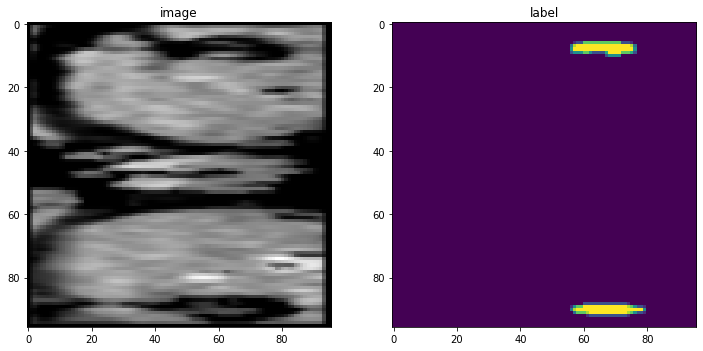

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


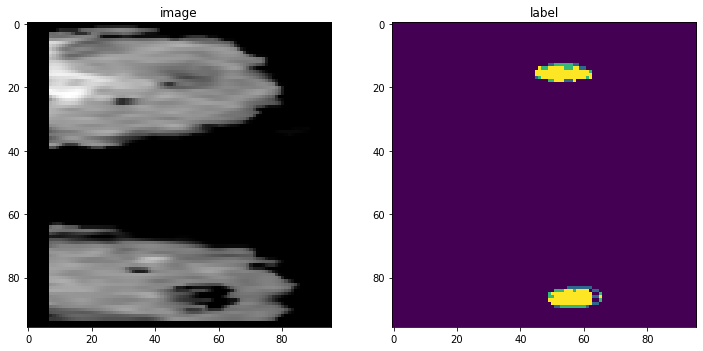

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


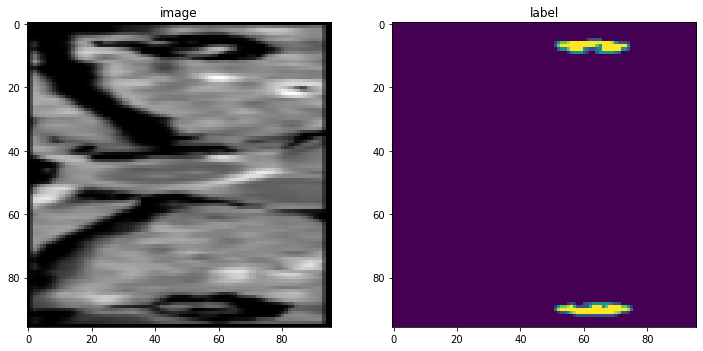

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


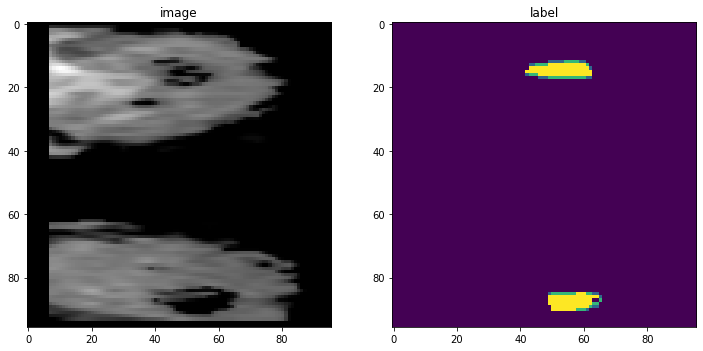

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


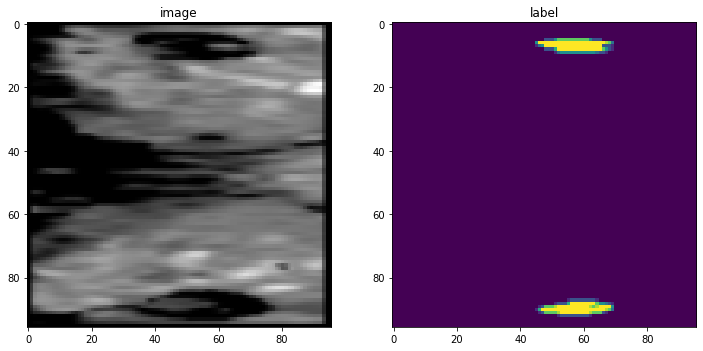

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


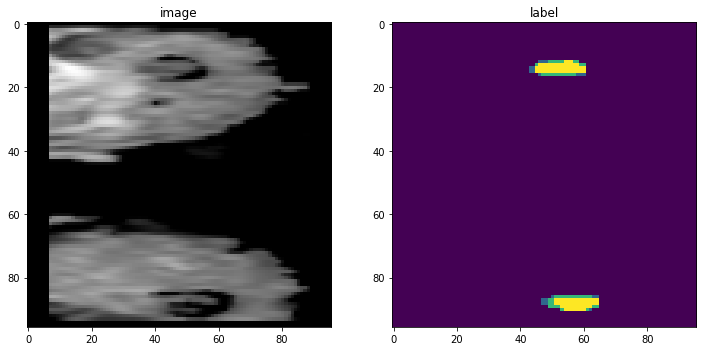

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


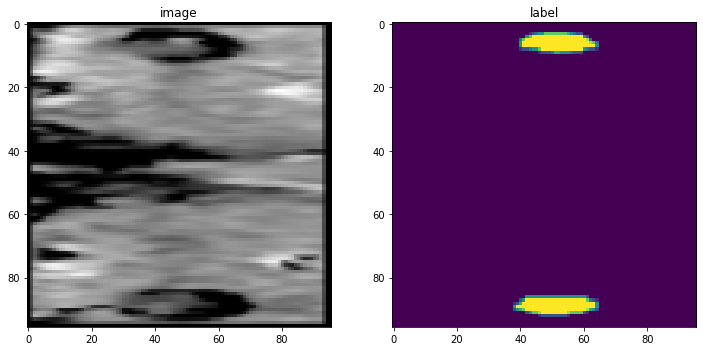

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


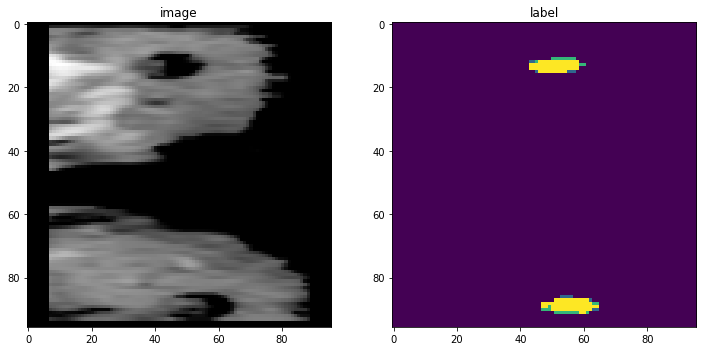

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


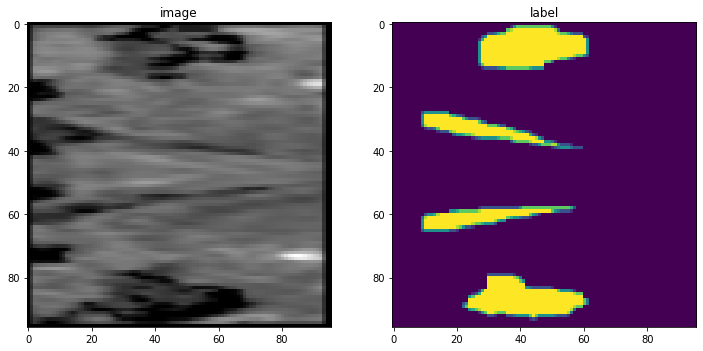

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


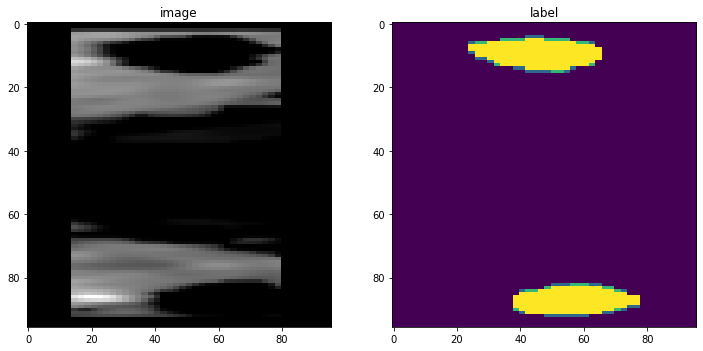

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


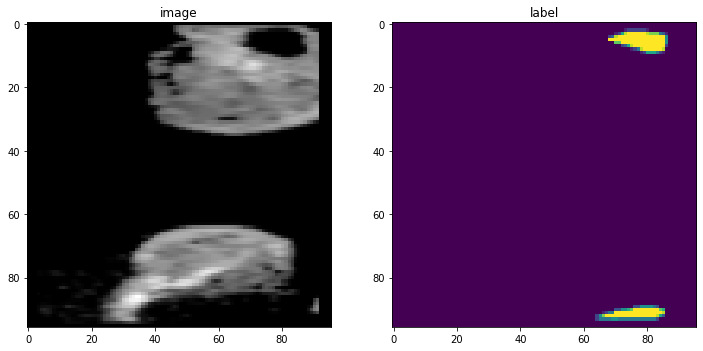

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


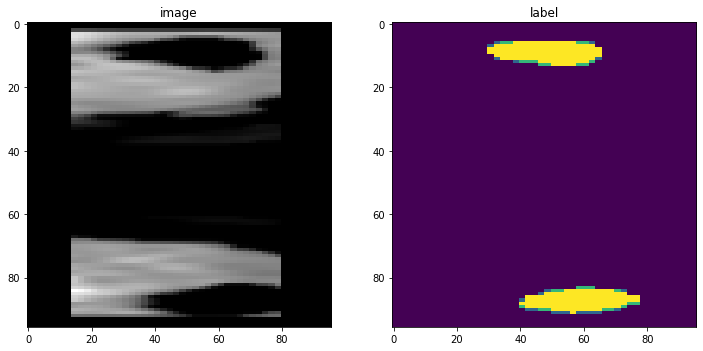

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


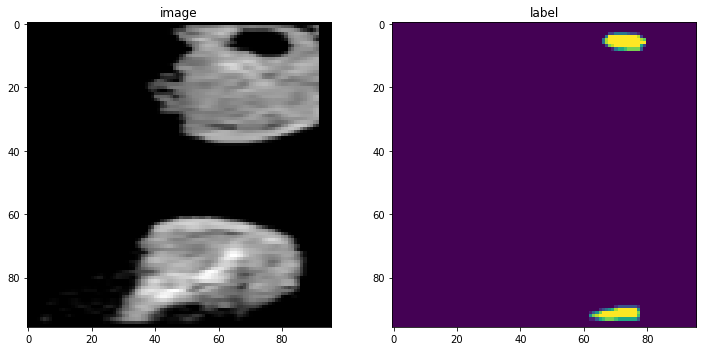

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


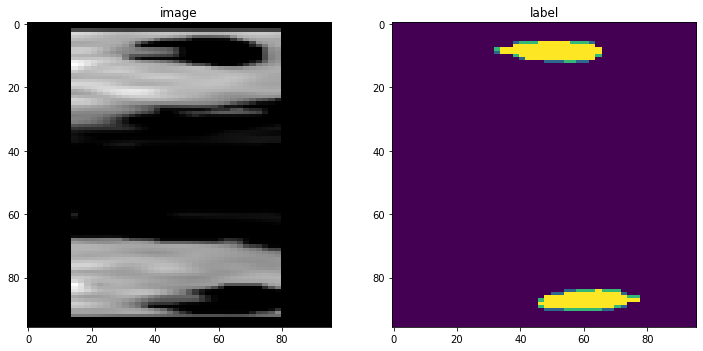

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


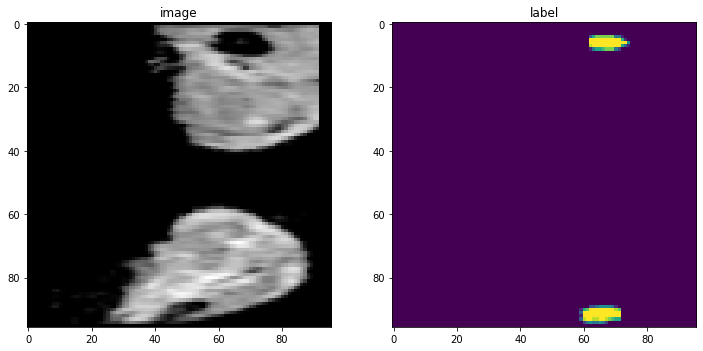

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


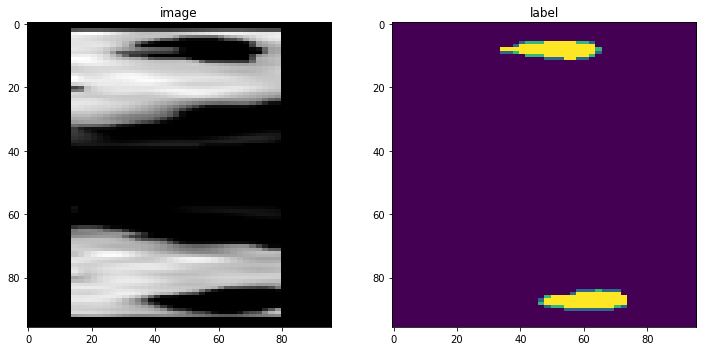

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


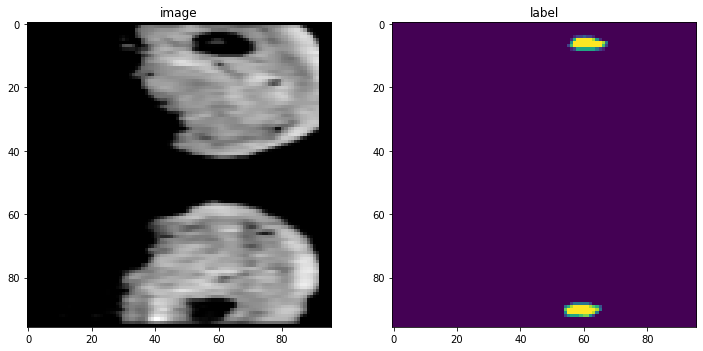

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


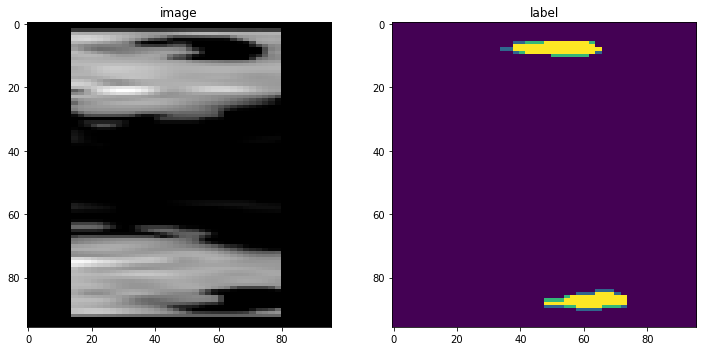

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


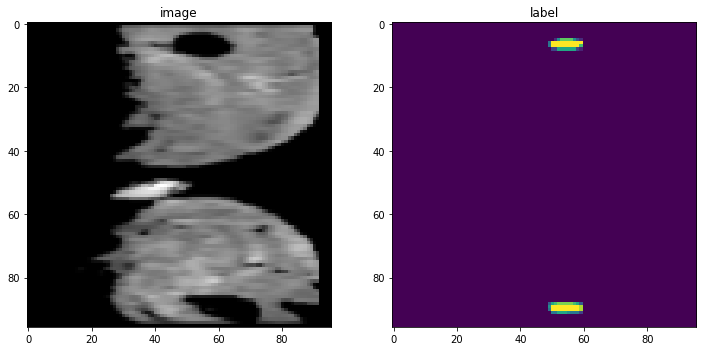

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


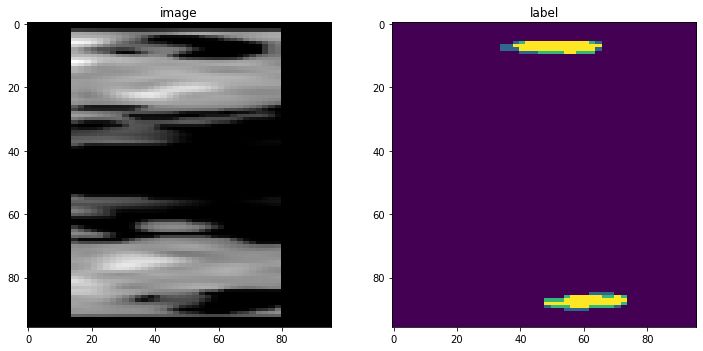

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


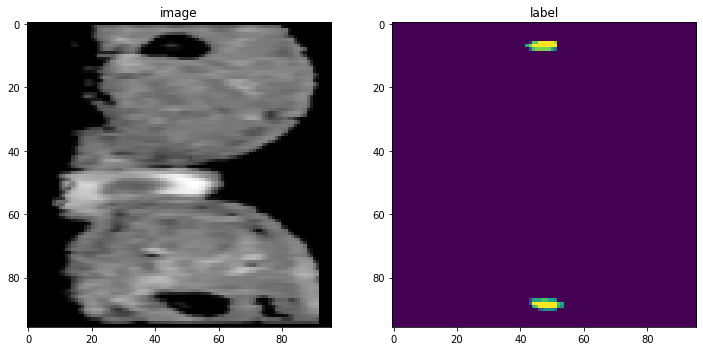

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


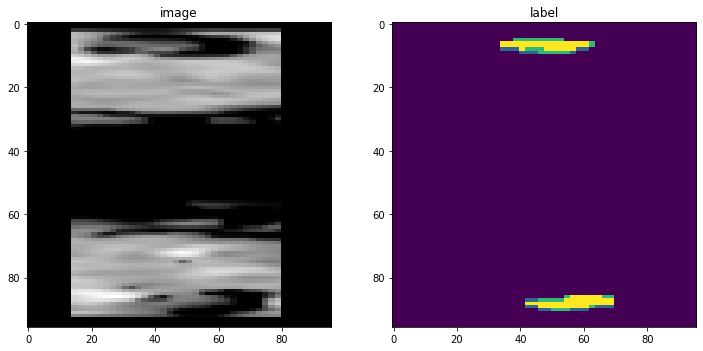

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


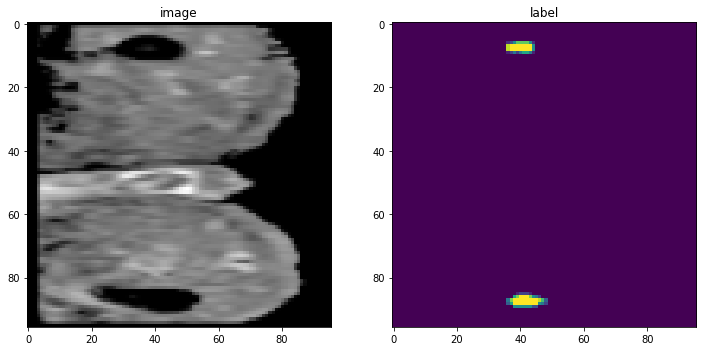

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


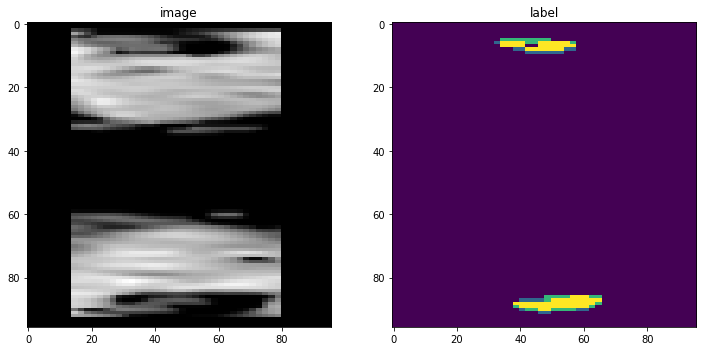

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


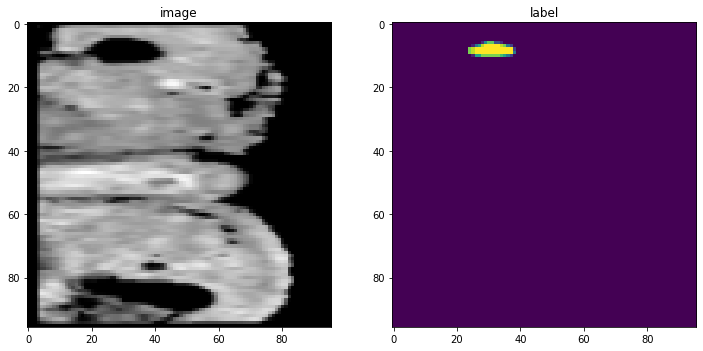

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


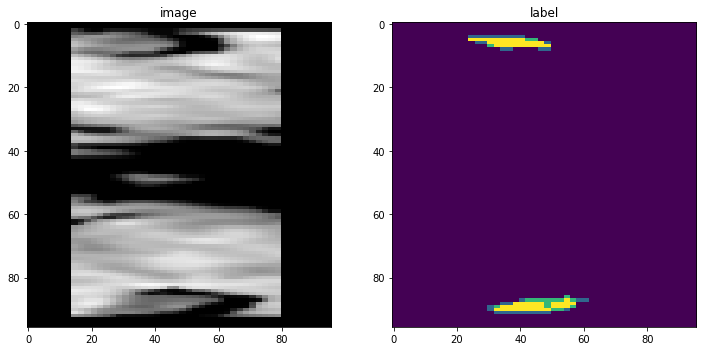

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


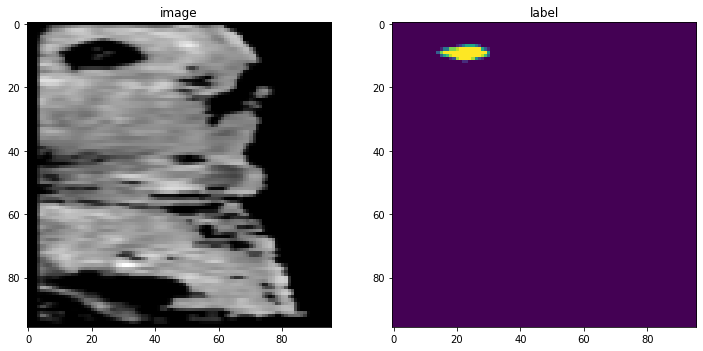

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


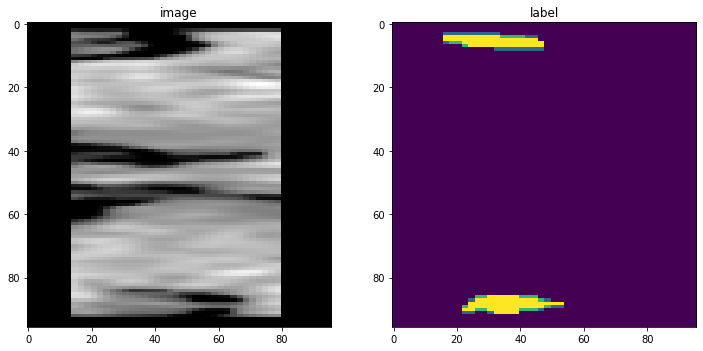

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


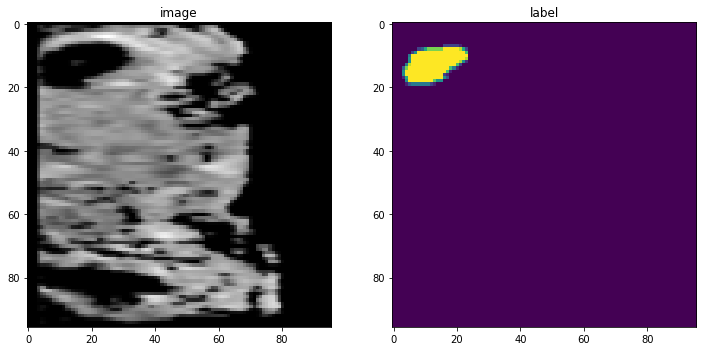

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


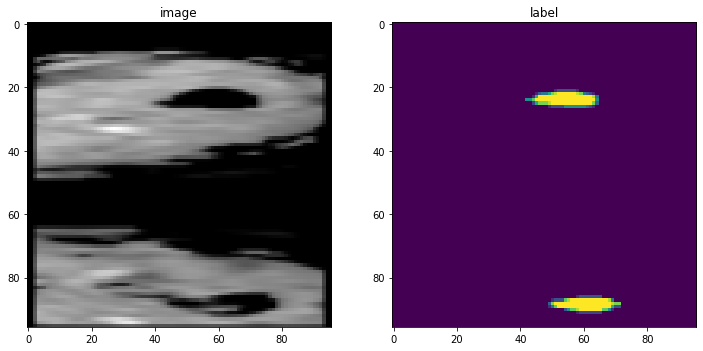

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


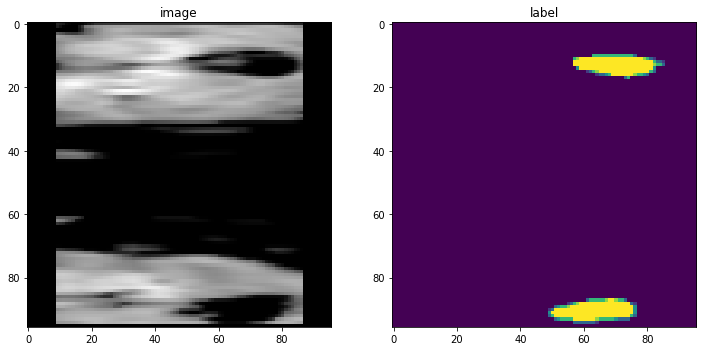

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


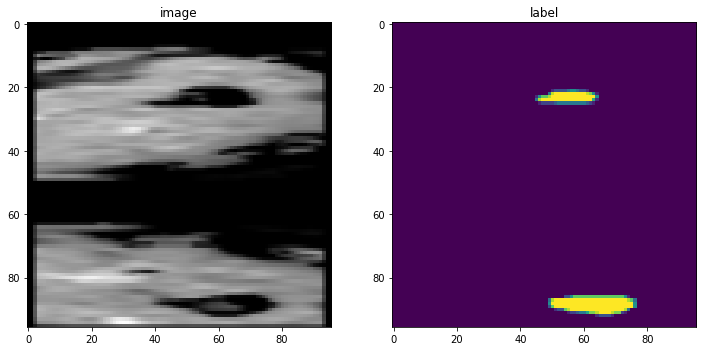

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


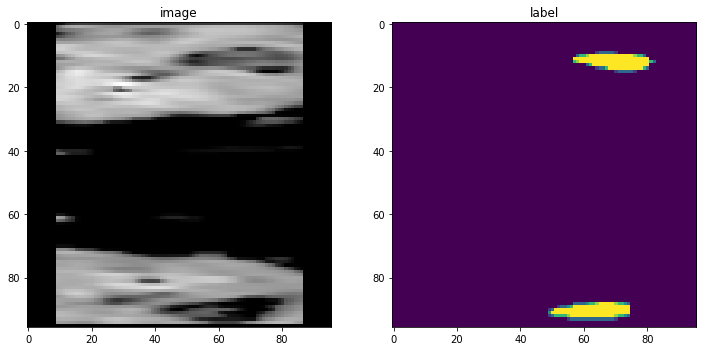

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


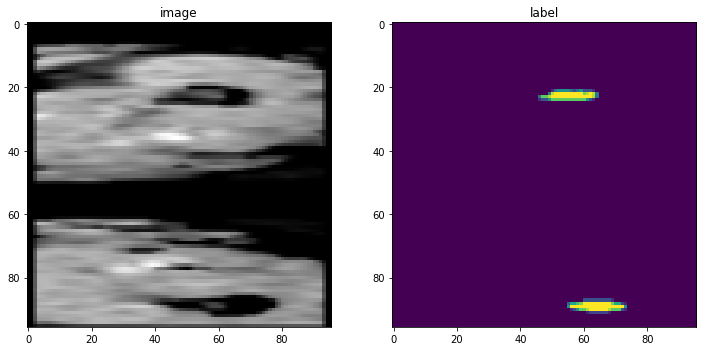

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


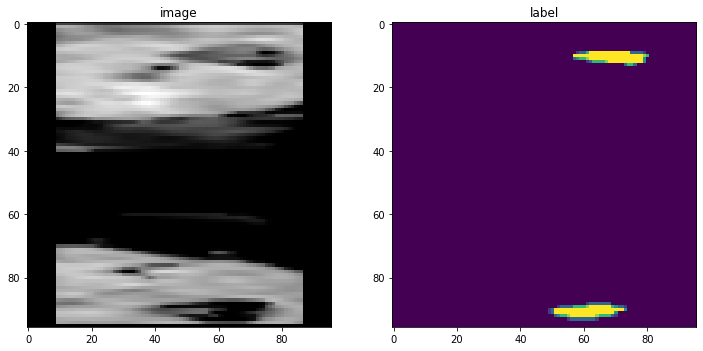

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


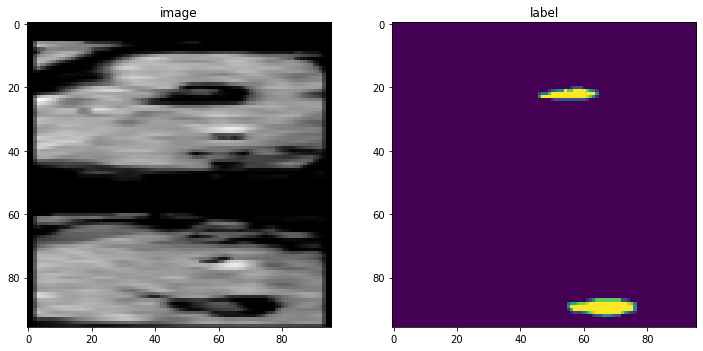

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


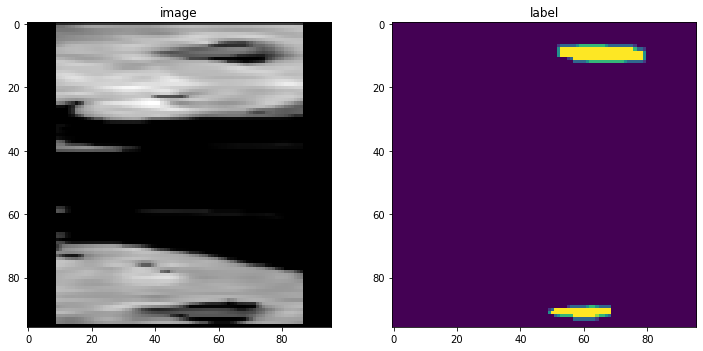

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


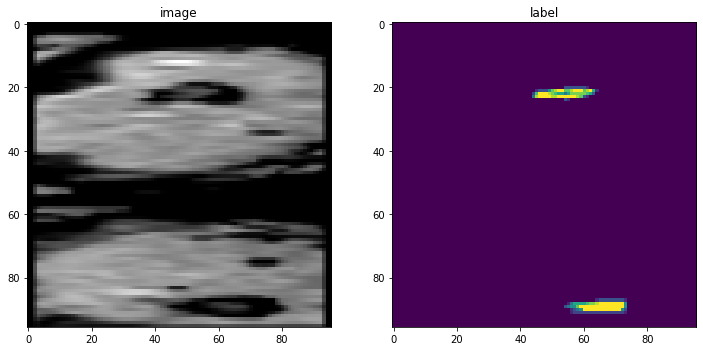

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


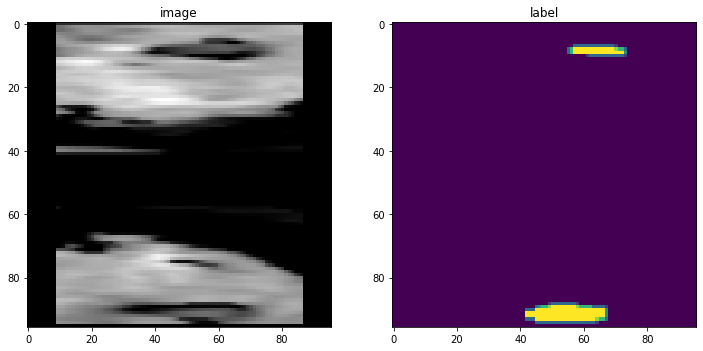

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


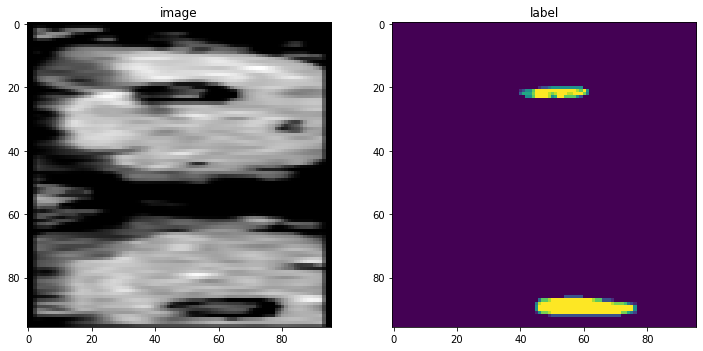

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


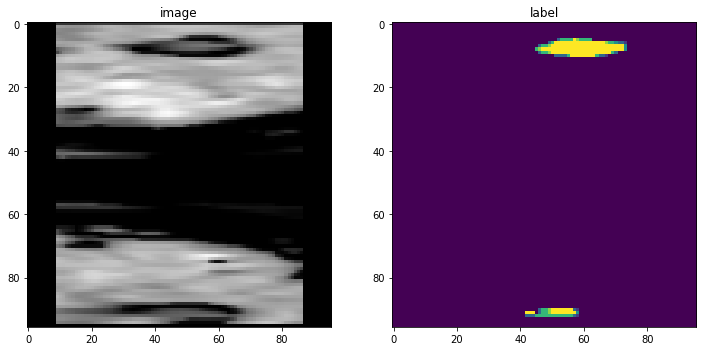

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


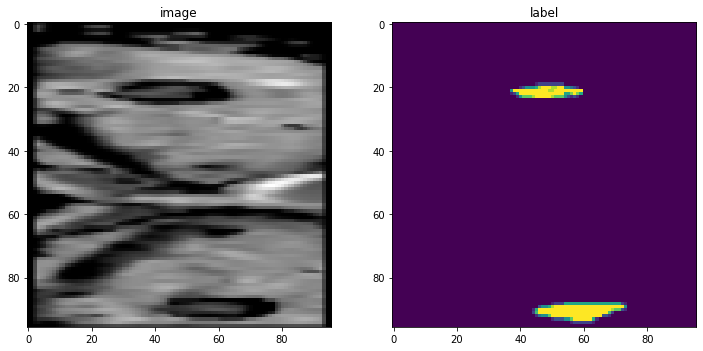

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


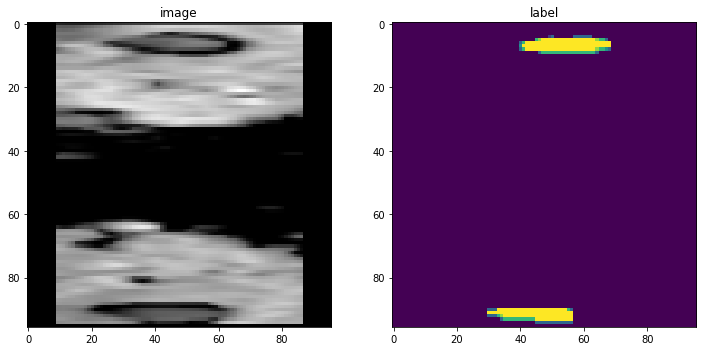

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


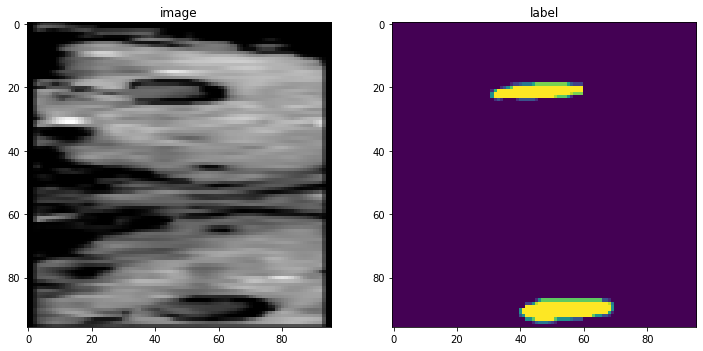

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


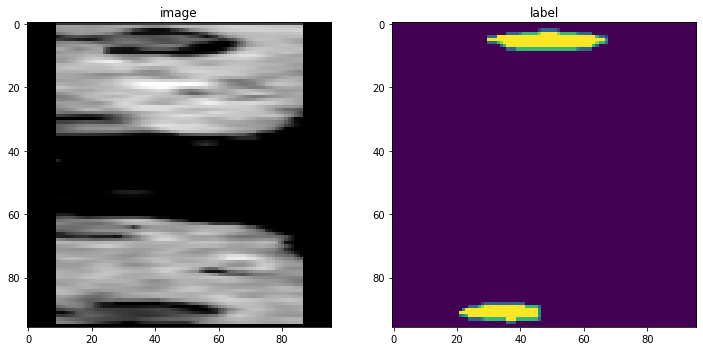

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


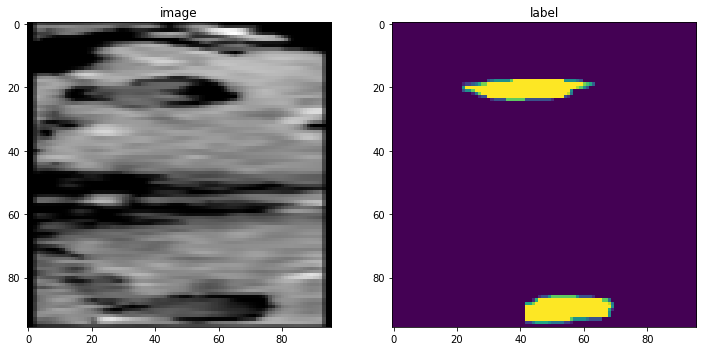

image shape: torch.Size([96, 96]), label shape: torch.Size([96, 96])


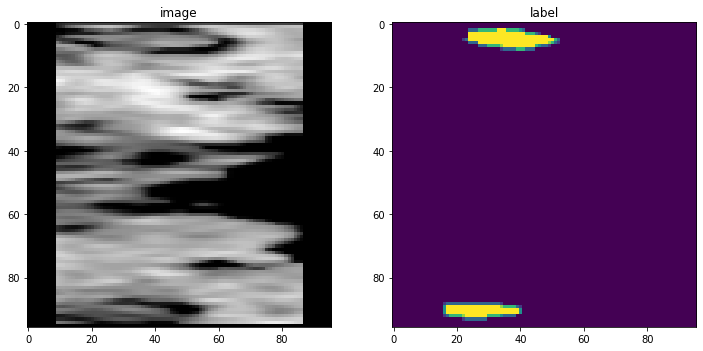

In [ ]:
for check_data in val_loader:
  image, label = (check_data["image"][0][0], check_data["label"][0][0])
  print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
  plt.figure("check", (12, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(image, cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label)
  plt.show()

## Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 5*1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [ ]:
from tqdm import tqdm

In [ ]:
max_epochs = 500
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|          | 0/500 [00:00<?, ?it/s]

----------
epoch 1/500
1/6, train_loss: 0.6233
2/6, train_loss: 0.5633
3/6, train_loss: 0.6256
4/6, train_loss: 0.5572
5/6, train_loss: 0.6289
6/6, train_loss: 0.5875
7/6, train_loss: 0.6314
8/6, train_loss: 0.5570
9/6, train_loss: 0.6319
10/6, train_loss: 0.5584
11/6, train_loss: 0.6329
12/6, train_loss: 0.5343
13/6, train_loss: 0.6332
14/6, train_loss: 0.5445
15/6, train_loss: 0.6336
16/6, train_loss: 0.6068
17/6, train_loss: 0.6336
18/6, train_loss: 0.6163
19/6, train_loss: 0.6328
20/6, train_loss: 0.6235
21/6, train_loss: 0.6318
22/6, train_loss: 0.6269
23/6, train_loss: 0.6285
24/6, train_loss: 0.6283
25/6, train_loss: 0.5859
26/6, train_loss: 0.5950
27/6, train_loss: 0.5941
28/6, train_loss: 0.5948
29/6, train_loss: 0.5969
30/6, train_loss: 0.5941
31/6, train_loss: 0.6018
32/6, train_loss: 0.5944
33/6, train_loss: 0.6001
34/6, train_loss: 0.6025
35/6, train_loss: 0.6015
36/6, train_loss: 0.6037
37/6, train_loss: 0.6038
38/6, train_loss: 0.6012
39/6, train_loss: 0.5997
40/6, train

  0%|          | 1/500 [00:27<3:46:02, 27.18s/it]

saved new best metric model
current epoch: 1 current mean dice: 0.1152
best mean dice: 0.1152 at epoch: 1
----------
epoch 2/500
1/6, train_loss: 0.5761
2/6, train_loss: 0.5189
3/6, train_loss: 0.5805
4/6, train_loss: 0.4986
5/6, train_loss: 0.5866
6/6, train_loss: 0.5289
7/6, train_loss: 0.5924
8/6, train_loss: 0.4877
9/6, train_loss: 0.5951
10/6, train_loss: 0.4962
11/6, train_loss: 0.5983
12/6, train_loss: 0.4629
13/6, train_loss: 0.6007
14/6, train_loss: 0.4751
15/6, train_loss: 0.6026
16/6, train_loss: 0.5565
17/6, train_loss: 0.6029
18/6, train_loss: 0.5731
19/6, train_loss: 0.6023
20/6, train_loss: 0.5850
21/6, train_loss: 0.6014
22/6, train_loss: 0.5897
23/6, train_loss: 0.5972
24/6, train_loss: 0.5938
25/6, train_loss: 0.5285
26/6, train_loss: 0.5430
27/6, train_loss: 0.5364
28/6, train_loss: 0.5421
29/6, train_loss: 0.5425
30/6, train_loss: 0.5404
31/6, train_loss: 0.5480
32/6, train_loss: 0.5388
33/6, train_loss: 0.5453
34/6, train_loss: 0.5497
35/6, train_loss: 0.5503
36/6,

  0%|          | 2/500 [00:54<3:45:42, 27.19s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.1505
best mean dice: 0.1505 at epoch: 2
----------
epoch 3/500
1/6, train_loss: 0.5535
2/6, train_loss: 0.4912
3/6, train_loss: 0.5585
4/6, train_loss: 0.4661
5/6, train_loss: 0.5664
6/6, train_loss: 0.4947
7/6, train_loss: 0.5743
8/6, train_loss: 0.4528
9/6, train_loss: 0.5779
10/6, train_loss: 0.4611
11/6, train_loss: 0.5818
12/6, train_loss: 0.4269
13/6, train_loss: 0.5848
14/6, train_loss: 0.4374
15/6, train_loss: 0.5875
16/6, train_loss: 0.5259
17/6, train_loss: 0.5878
18/6, train_loss: 0.5483
19/6, train_loss: 0.5870
20/6, train_loss: 0.5634
21/6, train_loss: 0.5867
22/6, train_loss: 0.5695
23/6, train_loss: 0.5818
24/6, train_loss: 0.5762
25/6, train_loss: 0.4966
26/6, train_loss: 0.5194
27/6, train_loss: 0.5027
28/6, train_loss: 0.5161
29/6, train_loss: 0.5107
30/6, train_loss: 0.5108
31/6, train_loss: 0.5175
32/6, train_loss: 0.5054
33/6, train_loss: 0.5144
34/6, train_loss: 0.5182
35/6, train_loss: 0.5210
36/6,

  1%|          | 3/500 [01:21<3:45:08, 27.18s/it]

saved new best metric model
current epoch: 3 current mean dice: 0.1632
best mean dice: 0.1632 at epoch: 3
----------
epoch 4/500
1/6, train_loss: 0.5319
2/6, train_loss: 0.4467
3/6, train_loss: 0.5378
4/6, train_loss: 0.4295
5/6, train_loss: 0.5476
6/6, train_loss: 0.4603
7/6, train_loss: 0.5575
8/6, train_loss: 0.4161
9/6, train_loss: 0.5621
10/6, train_loss: 0.4258
11/6, train_loss: 0.5673
12/6, train_loss: 0.3885
13/6, train_loss: 0.5709
14/6, train_loss: 0.3983
15/6, train_loss: 0.5747
16/6, train_loss: 0.4971
17/6, train_loss: 0.5749
18/6, train_loss: 0.5256
19/6, train_loss: 0.5738
20/6, train_loss: 0.5451
21/6, train_loss: 0.5738
22/6, train_loss: 0.5533
23/6, train_loss: 0.5675
24/6, train_loss: 0.5614
25/6, train_loss: 0.4611
26/6, train_loss: 0.4889
27/6, train_loss: 0.4682
28/6, train_loss: 0.4835
29/6, train_loss: 0.4788
30/6, train_loss: 0.4771
31/6, train_loss: 0.4889
32/6, train_loss: 0.4709
33/6, train_loss: 0.4862
34/6, train_loss: 0.4882
35/6, train_loss: 0.4947
36/6,

  1%|          | 4/500 [01:48<3:44:25, 27.15s/it]

saved new best metric model
current epoch: 4 current mean dice: 0.1712
best mean dice: 0.1712 at epoch: 4
----------
epoch 5/500
1/6, train_loss: 0.5063
2/6, train_loss: 0.3823
3/6, train_loss: 0.5137
4/6, train_loss: 0.3783
5/6, train_loss: 0.5262
6/6, train_loss: 0.4162
7/6, train_loss: 0.5384
8/6, train_loss: 0.3578
9/6, train_loss: 0.5452
10/6, train_loss: 0.3685
11/6, train_loss: 0.5519
12/6, train_loss: 0.3359
13/6, train_loss: 0.5571
14/6, train_loss: 0.3487
15/6, train_loss: 0.5625
16/6, train_loss: 0.4654
17/6, train_loss: 0.5625
18/6, train_loss: 0.5014
19/6, train_loss: 0.5602
20/6, train_loss: 0.5258
21/6, train_loss: 0.5601
22/6, train_loss: 0.5357
23/6, train_loss: 0.5510
24/6, train_loss: 0.5454
25/6, train_loss: 0.4171
26/6, train_loss: 0.4441
27/6, train_loss: 0.4266
28/6, train_loss: 0.4378
29/6, train_loss: 0.4409
30/6, train_loss: 0.4333
31/6, train_loss: 0.4554
32/6, train_loss: 0.4291
33/6, train_loss: 0.4529
34/6, train_loss: 0.4534
35/6, train_loss: 0.4635
36/6,

  1%|          | 5/500 [02:15<3:43:55, 27.14s/it]

current epoch: 5 current mean dice: 0.1688
best mean dice: 0.1712 at epoch: 4
----------
epoch 6/500
1/6, train_loss: 0.4775
2/6, train_loss: 0.3176
3/6, train_loss: 0.4881
4/6, train_loss: 0.3259
5/6, train_loss: 0.5045
6/6, train_loss: 0.3751
7/6, train_loss: 0.5195
8/6, train_loss: 0.3049
9/6, train_loss: 0.5276
10/6, train_loss: 0.3124
11/6, train_loss: 0.5357
12/6, train_loss: 0.2851
13/6, train_loss: 0.5420
14/6, train_loss: 0.2974
15/6, train_loss: 0.5482
16/6, train_loss: 0.4303
17/6, train_loss: 0.5479
18/6, train_loss: 0.4732
19/6, train_loss: 0.5455
20/6, train_loss: 0.5019
21/6, train_loss: 0.5452
22/6, train_loss: 0.5135
23/6, train_loss: 0.5342
24/6, train_loss: 0.5257
25/6, train_loss: 0.3724
26/6, train_loss: 0.3968
27/6, train_loss: 0.3836
28/6, train_loss: 0.3897
29/6, train_loss: 0.4011
30/6, train_loss: 0.3872
31/6, train_loss: 0.4190
32/6, train_loss: 0.3852
33/6, train_loss: 0.4158
34/6, train_loss: 0.4148
35/6, train_loss: 0.4275
36/6, train_loss: 0.4247
37/6, tr

  1%|          | 6/500 [02:42<3:43:30, 27.15s/it]

saved new best metric model
current epoch: 6 current mean dice: 0.2617
best mean dice: 0.2617 at epoch: 6
----------
epoch 7/500
1/6, train_loss: 0.4412
2/6, train_loss: 0.2754
3/6, train_loss: 0.4536
4/6, train_loss: 0.2929
5/6, train_loss: 0.4752
6/6, train_loss: 0.3330
7/6, train_loss: 0.4945
8/6, train_loss: 0.2631
9/6, train_loss: 0.5044
10/6, train_loss: 0.2584
11/6, train_loss: 0.5145
12/6, train_loss: 0.2495
13/6, train_loss: 0.5219
14/6, train_loss: 0.2568
15/6, train_loss: 0.5292
16/6, train_loss: 0.3822
17/6, train_loss: 0.5289
18/6, train_loss: 0.4345
19/6, train_loss: 0.5276
20/6, train_loss: 0.4697
21/6, train_loss: 0.5276
22/6, train_loss: 0.4837
23/6, train_loss: 0.5111
24/6, train_loss: 0.5009
25/6, train_loss: 0.3249
26/6, train_loss: 0.3392
27/6, train_loss: 0.3301
28/6, train_loss: 0.3296
29/6, train_loss: 0.3498
30/6, train_loss: 0.3279
31/6, train_loss: 0.3708
32/6, train_loss: 0.3254
33/6, train_loss: 0.3661
34/6, train_loss: 0.3599
35/6, train_loss: 0.3795
36/6,

  1%|▏         | 7/500 [03:10<3:43:54, 27.25s/it]

saved new best metric model
current epoch: 7 current mean dice: 0.2791
best mean dice: 0.2791 at epoch: 7
----------
epoch 8/500
1/6, train_loss: 0.4076
2/6, train_loss: 0.2441
3/6, train_loss: 0.4189
4/6, train_loss: 0.2640
5/6, train_loss: 0.4464
6/6, train_loss: 0.2878
7/6, train_loss: 0.4707
8/6, train_loss: 0.2246
9/6, train_loss: 0.4831
10/6, train_loss: 0.2198
11/6, train_loss: 0.4958
12/6, train_loss: 0.2372
13/6, train_loss: 0.5054
14/6, train_loss: 0.2406
15/6, train_loss: 0.5151
16/6, train_loss: 0.3422
17/6, train_loss: 0.5132
18/6, train_loss: 0.3971
19/6, train_loss: 0.5106
20/6, train_loss: 0.4396
21/6, train_loss: 0.5101
22/6, train_loss: 0.4578
23/6, train_loss: 0.4897
24/6, train_loss: 0.4774
25/6, train_loss: 0.2898
26/6, train_loss: 0.2898
27/6, train_loss: 0.2886
28/6, train_loss: 0.2780
29/6, train_loss: 0.3041
30/6, train_loss: 0.2777
31/6, train_loss: 0.3273
32/6, train_loss: 0.2781
33/6, train_loss: 0.3222
34/6, train_loss: 0.3139
35/6, train_loss: 0.3382
36/6,

  2%|▏         | 8/500 [03:37<3:42:28, 27.13s/it]

current epoch: 8 current mean dice: 0.2740
best mean dice: 0.2791 at epoch: 7
----------
epoch 9/500
1/6, train_loss: 0.3678
2/6, train_loss: 0.2143
3/6, train_loss: 0.3838
4/6, train_loss: 0.2422
5/6, train_loss: 0.4165
6/6, train_loss: 0.2522
7/6, train_loss: 0.4467
8/6, train_loss: 0.2005
9/6, train_loss: 0.4618
10/6, train_loss: 0.2032
11/6, train_loss: 0.4793
12/6, train_loss: 0.2304
13/6, train_loss: 0.4900
14/6, train_loss: 0.2306
15/6, train_loss: 0.5020
16/6, train_loss: 0.2957
17/6, train_loss: 0.4988
18/6, train_loss: 0.3553
19/6, train_loss: 0.4962
20/6, train_loss: 0.4057
21/6, train_loss: 0.4962
22/6, train_loss: 0.4262
23/6, train_loss: 0.4693
24/6, train_loss: 0.4496
25/6, train_loss: 0.2513
26/6, train_loss: 0.2461
27/6, train_loss: 0.2429
28/6, train_loss: 0.2345
29/6, train_loss: 0.2605
30/6, train_loss: 0.2315
31/6, train_loss: 0.2841
32/6, train_loss: 0.2287
33/6, train_loss: 0.2786
34/6, train_loss: 0.2659
35/6, train_loss: 0.2978
36/6, train_loss: 0.2786
37/6, tr

  2%|▏         | 9/500 [04:04<3:42:35, 27.20s/it]

saved new best metric model
current epoch: 9 current mean dice: 0.2809
best mean dice: 0.2809 at epoch: 9
----------
epoch 10/500
1/6, train_loss: 0.3282
2/6, train_loss: 0.1984
3/6, train_loss: 0.3488
4/6, train_loss: 0.2229
5/6, train_loss: 0.3868
6/6, train_loss: 0.2225
7/6, train_loss: 0.4218
8/6, train_loss: 0.1873
9/6, train_loss: 0.4399
10/6, train_loss: 0.1844
11/6, train_loss: 0.4600
12/6, train_loss: 0.2033
13/6, train_loss: 0.4748
14/6, train_loss: 0.2287
15/6, train_loss: 0.4907
16/6, train_loss: 0.2767
17/6, train_loss: 0.4877
18/6, train_loss: 0.3125
19/6, train_loss: 0.4861
20/6, train_loss: 0.3701
21/6, train_loss: 0.4842
22/6, train_loss: 0.3945
23/6, train_loss: 0.4504
24/6, train_loss: 0.4253
25/6, train_loss: 0.2175
26/6, train_loss: 0.2057
27/6, train_loss: 0.2026
28/6, train_loss: 0.1945
29/6, train_loss: 0.2210
30/6, train_loss: 0.1924
31/6, train_loss: 0.2442
32/6, train_loss: 0.1901
33/6, train_loss: 0.2373
34/6, train_loss: 0.2200
35/6, train_loss: 0.2548
36/6

  2%|▏         | 10/500 [04:31<3:41:43, 27.15s/it]

current epoch: 10 current mean dice: 0.1857
best mean dice: 0.2809 at epoch: 9
----------
epoch 11/500
1/6, train_loss: 0.3002
2/6, train_loss: 0.2273
3/6, train_loss: 0.3096
4/6, train_loss: 0.2215
5/6, train_loss: 0.3516
6/6, train_loss: 0.2003
7/6, train_loss: 0.3903
8/6, train_loss: 0.1584
9/6, train_loss: 0.4142
10/6, train_loss: 0.1674
11/6, train_loss: 0.4374
12/6, train_loss: 0.2042
13/6, train_loss: 0.4564
14/6, train_loss: 0.2004
15/6, train_loss: 0.4772
16/6, train_loss: 0.2134
17/6, train_loss: 0.4729
18/6, train_loss: 0.2702
19/6, train_loss: 0.4710
20/6, train_loss: 0.3281
21/6, train_loss: 0.4695
22/6, train_loss: 0.3537
23/6, train_loss: 0.4306
24/6, train_loss: 0.4053
25/6, train_loss: 0.2386
26/6, train_loss: 0.1900
27/6, train_loss: 0.1913
28/6, train_loss: 0.1698
29/6, train_loss: 0.1841
30/6, train_loss: 0.1655
31/6, train_loss: 0.2122
32/6, train_loss: 0.1616
33/6, train_loss: 0.2060
34/6, train_loss: 0.1875
35/6, train_loss: 0.2267
36/6, train_loss: 0.1934
37/6, 

  2%|▏         | 11/500 [04:58<3:40:47, 27.09s/it]

current epoch: 11 current mean dice: 0.2211
best mean dice: 0.2809 at epoch: 9
----------
epoch 12/500
1/6, train_loss: 0.2527
2/6, train_loss: 0.1640
3/6, train_loss: 0.2740
4/6, train_loss: 0.2116
5/6, train_loss: 0.3170
6/6, train_loss: 0.1839
7/6, train_loss: 0.3572
8/6, train_loss: 0.1407
9/6, train_loss: 0.3797
10/6, train_loss: 0.1380
11/6, train_loss: 0.4094
12/6, train_loss: 0.1835
13/6, train_loss: 0.4343
14/6, train_loss: 0.1896
15/6, train_loss: 0.4594
16/6, train_loss: 0.1739
17/6, train_loss: 0.4551
18/6, train_loss: 0.2209
19/6, train_loss: 0.4528
20/6, train_loss: 0.2807
21/6, train_loss: 0.4511
22/6, train_loss: 0.3144
23/6, train_loss: 0.4056
24/6, train_loss: 0.3433
25/6, train_loss: 0.2177
26/6, train_loss: 0.1522
27/6, train_loss: 0.1693
28/6, train_loss: 0.1407
29/6, train_loss: 0.1610
30/6, train_loss: 0.1350
31/6, train_loss: 0.1827
32/6, train_loss: 0.1363
33/6, train_loss: 0.1734
34/6, train_loss: 0.1545
35/6, train_loss: 0.1927
36/6, train_loss: 0.1580
37/6, 

  2%|▏         | 12/500 [05:25<3:39:06, 26.94s/it]

current epoch: 12 current mean dice: 0.2464
best mean dice: 0.2809 at epoch: 9
----------
epoch 13/500
1/6, train_loss: 0.2197
2/6, train_loss: 0.1417
3/6, train_loss: 0.2351
4/6, train_loss: 0.1749
5/6, train_loss: 0.2696
6/6, train_loss: 0.1789
7/6, train_loss: 0.3305
8/6, train_loss: 0.1311
9/6, train_loss: 0.3400
10/6, train_loss: 0.1361
11/6, train_loss: 0.3826
12/6, train_loss: 0.1625
13/6, train_loss: 0.4172
14/6, train_loss: 0.1679
15/6, train_loss: 0.4460
16/6, train_loss: 0.1430
17/6, train_loss: 0.4394
18/6, train_loss: 0.1755
19/6, train_loss: 0.4368
20/6, train_loss: 0.2378
21/6, train_loss: 0.4340
22/6, train_loss: 0.2668
23/6, train_loss: 0.3784
24/6, train_loss: 0.3019
25/6, train_loss: 0.1788
26/6, train_loss: 0.1299
27/6, train_loss: 0.1496
28/6, train_loss: 0.1178
29/6, train_loss: 0.1472
30/6, train_loss: 0.1195
31/6, train_loss: 0.1613
32/6, train_loss: 0.1262
33/6, train_loss: 0.1498
34/6, train_loss: 0.1317
35/6, train_loss: 0.1595
36/6, train_loss: 0.1214
37/6, 

  3%|▎         | 13/500 [05:52<3:39:20, 27.02s/it]

saved new best metric model
current epoch: 13 current mean dice: 0.2951
best mean dice: 0.2951 at epoch: 13
----------
epoch 14/500
1/6, train_loss: 0.1897
2/6, train_loss: 0.1342
3/6, train_loss: 0.2104
4/6, train_loss: 0.1621
5/6, train_loss: 0.2408
6/6, train_loss: 0.1592
7/6, train_loss: 0.2864
8/6, train_loss: 0.1072
9/6, train_loss: 0.3173
10/6, train_loss: 0.1061
11/6, train_loss: 0.3464
12/6, train_loss: 0.1508
13/6, train_loss: 0.3808
14/6, train_loss: 0.1614
15/6, train_loss: 0.4297
16/6, train_loss: 0.1255
17/6, train_loss: 0.4201
18/6, train_loss: 0.1490
19/6, train_loss: 0.4167
20/6, train_loss: 0.2047
21/6, train_loss: 0.4161
22/6, train_loss: 0.2310
23/6, train_loss: 0.3506
24/6, train_loss: 0.2724
25/6, train_loss: 0.1834
26/6, train_loss: 0.1126
27/6, train_loss: 0.1424
28/6, train_loss: 0.1016
29/6, train_loss: 0.1270
30/6, train_loss: 0.0975
31/6, train_loss: 0.1451
32/6, train_loss: 0.0954
33/6, train_loss: 0.1331
34/6, train_loss: 0.1108
35/6, train_loss: 0.1422
36

  3%|▎         | 14/500 [06:19<3:37:51, 26.90s/it]

current epoch: 14 current mean dice: 0.2623
best mean dice: 0.2951 at epoch: 13
----------
epoch 15/500
1/6, train_loss: 0.1607
2/6, train_loss: 0.1245
3/6, train_loss: 0.1797
4/6, train_loss: 0.1496
5/6, train_loss: 0.2123
6/6, train_loss: 0.1564
7/6, train_loss: 0.2743
8/6, train_loss: 0.1006
9/6, train_loss: 0.2933
10/6, train_loss: 0.1114
11/6, train_loss: 0.3166
12/6, train_loss: 0.1402
13/6, train_loss: 0.3514
14/6, train_loss: 0.1492
15/6, train_loss: 0.4040
16/6, train_loss: 0.1058
17/6, train_loss: 0.3975
18/6, train_loss: 0.1186
19/6, train_loss: 0.3938
20/6, train_loss: 0.1715
21/6, train_loss: 0.3866
22/6, train_loss: 0.2005
23/6, train_loss: 0.3152
24/6, train_loss: 0.2370
25/6, train_loss: 0.1682
26/6, train_loss: 0.1188
27/6, train_loss: 0.1386
28/6, train_loss: 0.1060
29/6, train_loss: 0.1223
30/6, train_loss: 0.0933
31/6, train_loss: 0.1297
32/6, train_loss: 0.0872
33/6, train_loss: 0.1315
34/6, train_loss: 0.1009
35/6, train_loss: 0.1367
36/6, train_loss: 0.1005
37/6,

  3%|▎         | 15/500 [06:45<3:36:45, 26.82s/it]

current epoch: 15 current mean dice: 0.1167
best mean dice: 0.2951 at epoch: 13
----------
epoch 16/500
1/6, train_loss: 0.1442
2/6, train_loss: 0.1319
3/6, train_loss: 0.1634
4/6, train_loss: 0.1637
5/6, train_loss: 0.1973
6/6, train_loss: 0.1491
7/6, train_loss: 0.2297
8/6, train_loss: 0.0898
9/6, train_loss: 0.2505
10/6, train_loss: 0.0912
11/6, train_loss: 0.2903
12/6, train_loss: 0.1471
13/6, train_loss: 0.3238
14/6, train_loss: 0.1367
15/6, train_loss: 0.3747
16/6, train_loss: 0.0908
17/6, train_loss: 0.3712
18/6, train_loss: 0.1134
19/6, train_loss: 0.3747
20/6, train_loss: 0.1498
21/6, train_loss: 0.3509
22/6, train_loss: 0.1766
23/6, train_loss: 0.2991
24/6, train_loss: 0.2212
25/6, train_loss: 0.1871
26/6, train_loss: 0.0963
27/6, train_loss: 0.1277
28/6, train_loss: 0.0859
29/6, train_loss: 0.1062
30/6, train_loss: 0.0793
31/6, train_loss: 0.1257
32/6, train_loss: 0.0755
33/6, train_loss: 0.1152
34/6, train_loss: 0.0835
35/6, train_loss: 0.1230
36/6, train_loss: 0.0804
37/6,

  3%|▎         | 16/500 [07:13<3:38:06, 27.04s/it]

current epoch: 16 current mean dice: 0.2942
best mean dice: 0.2951 at epoch: 13
----------
epoch 17/500
1/6, train_loss: 0.1311
2/6, train_loss: 0.1163
3/6, train_loss: 0.1391
4/6, train_loss: 0.1360
5/6, train_loss: 0.1833
6/6, train_loss: 0.1393
7/6, train_loss: 0.2210
8/6, train_loss: 0.0848
9/6, train_loss: 0.2375
10/6, train_loss: 0.0856
11/6, train_loss: 0.2765
12/6, train_loss: 0.1161
13/6, train_loss: 0.3198
14/6, train_loss: 0.1252
15/6, train_loss: 0.3735
16/6, train_loss: 0.1158
17/6, train_loss: 0.3739
18/6, train_loss: 0.1192
19/6, train_loss: 0.3639
20/6, train_loss: 0.1453
21/6, train_loss: 0.3506
22/6, train_loss: 0.1608
23/6, train_loss: 0.2644
24/6, train_loss: 0.1945
25/6, train_loss: 0.1554
26/6, train_loss: 0.0848
27/6, train_loss: 0.1275
28/6, train_loss: 0.0804
29/6, train_loss: 0.1038
30/6, train_loss: 0.0869
31/6, train_loss: 0.1203
32/6, train_loss: 0.0866
33/6, train_loss: 0.1032
34/6, train_loss: 0.0800
35/6, train_loss: 0.1008
36/6, train_loss: 0.0812
37/6,

  3%|▎         | 17/500 [07:39<3:36:49, 26.94s/it]

current epoch: 17 current mean dice: 0.2026
best mean dice: 0.2951 at epoch: 13
----------
epoch 18/500
1/6, train_loss: 0.1322
2/6, train_loss: 0.0973
3/6, train_loss: 0.1437
4/6, train_loss: 0.1399
5/6, train_loss: 0.1473
6/6, train_loss: 0.1344
7/6, train_loss: 0.1701
8/6, train_loss: 0.0844
9/6, train_loss: 0.2323
10/6, train_loss: 0.0868
11/6, train_loss: 0.2436
12/6, train_loss: 0.1141
13/6, train_loss: 0.2799
14/6, train_loss: 0.1312
15/6, train_loss: 0.3364
16/6, train_loss: 0.1028
17/6, train_loss: 0.3461
18/6, train_loss: 0.0915
19/6, train_loss: 0.3325
20/6, train_loss: 0.1337
21/6, train_loss: 0.3119
22/6, train_loss: 0.1480
23/6, train_loss: 0.2360
24/6, train_loss: 0.1790
25/6, train_loss: 0.1617
26/6, train_loss: 0.0995
27/6, train_loss: 0.1206
28/6, train_loss: 0.0791
29/6, train_loss: 0.1112
30/6, train_loss: 0.0744
31/6, train_loss: 0.1195
32/6, train_loss: 0.0705
33/6, train_loss: 0.0966
34/6, train_loss: 0.0725
35/6, train_loss: 0.1011
36/6, train_loss: 0.0634
37/6,

  4%|▎         | 18/500 [08:06<3:35:29, 26.82s/it]

current epoch: 18 current mean dice: 0.2251
best mean dice: 0.2951 at epoch: 13
----------
epoch 19/500
1/6, train_loss: 0.1204
2/6, train_loss: 0.1051
3/6, train_loss: 0.1251
4/6, train_loss: 0.1336
5/6, train_loss: 0.1401
6/6, train_loss: 0.1233
7/6, train_loss: 0.1780
8/6, train_loss: 0.0719
9/6, train_loss: 0.1976
10/6, train_loss: 0.0746
11/6, train_loss: 0.2406
12/6, train_loss: 0.1092
13/6, train_loss: 0.2717
14/6, train_loss: 0.1291
15/6, train_loss: 0.3297
16/6, train_loss: 0.0808
17/6, train_loss: 0.3456
18/6, train_loss: 0.0729
19/6, train_loss: 0.3277
20/6, train_loss: 0.1072
21/6, train_loss: 0.3034
22/6, train_loss: 0.1241
23/6, train_loss: 0.2285
24/6, train_loss: 0.1612
25/6, train_loss: 0.0996
26/6, train_loss: 0.1074
27/6, train_loss: 0.0930
28/6, train_loss: 0.0900
29/6, train_loss: 0.1014
30/6, train_loss: 0.0708
31/6, train_loss: 0.1166
32/6, train_loss: 0.0641
33/6, train_loss: 0.1030
34/6, train_loss: 0.0859
35/6, train_loss: 0.1189
36/6, train_loss: 0.0699
37/6,

  4%|▍         | 19/500 [08:33<3:35:20, 26.86s/it]

current epoch: 19 current mean dice: 0.1661
best mean dice: 0.2951 at epoch: 13
----------
epoch 20/500
1/6, train_loss: 0.1043
2/6, train_loss: 0.0981
3/6, train_loss: 0.1144
4/6, train_loss: 0.1552
5/6, train_loss: 0.1387
6/6, train_loss: 0.1185
7/6, train_loss: 0.1661
8/6, train_loss: 0.0728
9/6, train_loss: 0.1858
10/6, train_loss: 0.0716
11/6, train_loss: 0.2278
12/6, train_loss: 0.1119
13/6, train_loss: 0.3129
14/6, train_loss: 0.1254
15/6, train_loss: 0.3560
16/6, train_loss: 0.0630
17/6, train_loss: 0.3186
18/6, train_loss: 0.0741
19/6, train_loss: 0.2763
20/6, train_loss: 0.1076
21/6, train_loss: 0.2901
22/6, train_loss: 0.1319
23/6, train_loss: 0.2198
24/6, train_loss: 0.1527
25/6, train_loss: 0.1270
26/6, train_loss: 0.0742
27/6, train_loss: 0.0933
28/6, train_loss: 0.0711
29/6, train_loss: 0.0974
30/6, train_loss: 0.0709
31/6, train_loss: 0.1163
32/6, train_loss: 0.0652
33/6, train_loss: 0.0930
34/6, train_loss: 0.0770
35/6, train_loss: 0.1033
36/6, train_loss: 0.0611
37/6,

  4%|▍         | 20/500 [09:00<3:34:16, 26.78s/it]

current epoch: 20 current mean dice: 0.2092
best mean dice: 0.2951 at epoch: 13
----------
epoch 21/500
1/6, train_loss: 0.0961
2/6, train_loss: 0.0969
3/6, train_loss: 0.0861
4/6, train_loss: 0.1324
5/6, train_loss: 0.1207
6/6, train_loss: 0.1175
7/6, train_loss: 0.1426
8/6, train_loss: 0.0637
9/6, train_loss: 0.1589
10/6, train_loss: 0.0683
11/6, train_loss: 0.1955
12/6, train_loss: 0.1101
13/6, train_loss: 0.2124
14/6, train_loss: 0.1218
15/6, train_loss: 0.2644
16/6, train_loss: 0.0738
17/6, train_loss: 0.2556
18/6, train_loss: 0.0801
19/6, train_loss: 0.3266
20/6, train_loss: 0.0931
21/6, train_loss: 0.3174
22/6, train_loss: 0.1108
23/6, train_loss: 0.1960
24/6, train_loss: 0.1352
25/6, train_loss: 0.1025
26/6, train_loss: 0.0586
27/6, train_loss: 0.0781
28/6, train_loss: 0.0536
29/6, train_loss: 0.0859
30/6, train_loss: 0.0514
31/6, train_loss: 0.1021
32/6, train_loss: 0.0519
33/6, train_loss: 0.0892
34/6, train_loss: 0.0575
35/6, train_loss: 0.0905
36/6, train_loss: 0.0566
37/6,

  4%|▍         | 21/500 [09:26<3:33:28, 26.74s/it]

current epoch: 21 current mean dice: 0.1851
best mean dice: 0.2951 at epoch: 13
----------
epoch 22/500
1/6, train_loss: 0.0796
2/6, train_loss: 0.0914
3/6, train_loss: 0.0854
4/6, train_loss: 0.1369
5/6, train_loss: 0.1000
6/6, train_loss: 0.1057
7/6, train_loss: 0.1096
8/6, train_loss: 0.0698
9/6, train_loss: 0.1335
10/6, train_loss: 0.0642
11/6, train_loss: 0.1829
12/6, train_loss: 0.0996
13/6, train_loss: 0.2205
14/6, train_loss: 0.1098
15/6, train_loss: 0.2919
16/6, train_loss: 0.0845
17/6, train_loss: 0.2957
18/6, train_loss: 0.0781
19/6, train_loss: 0.2585
20/6, train_loss: 0.1185
21/6, train_loss: 0.2519
22/6, train_loss: 0.1144
23/6, train_loss: 0.1756
24/6, train_loss: 0.1413
25/6, train_loss: 0.1164
26/6, train_loss: 0.0648
27/6, train_loss: 0.0844
28/6, train_loss: 0.0515
29/6, train_loss: 0.0832
30/6, train_loss: 0.0501
31/6, train_loss: 0.0979
32/6, train_loss: 0.0507
33/6, train_loss: 0.0840
34/6, train_loss: 0.0662
35/6, train_loss: 0.0845
36/6, train_loss: 0.0507
37/6,

  4%|▍         | 22/500 [09:53<3:33:41, 26.82s/it]

current epoch: 22 current mean dice: 0.1097
best mean dice: 0.2951 at epoch: 13
----------
epoch 23/500
1/6, train_loss: 0.0835
2/6, train_loss: 0.0882
3/6, train_loss: 0.0901
4/6, train_loss: 0.1139
5/6, train_loss: 0.0879
6/6, train_loss: 0.1076
7/6, train_loss: 0.1138
8/6, train_loss: 0.0658
9/6, train_loss: 0.1455
10/6, train_loss: 0.0624
11/6, train_loss: 0.1637
12/6, train_loss: 0.1004
13/6, train_loss: 0.2025
14/6, train_loss: 0.1054
15/6, train_loss: 0.2620
16/6, train_loss: 0.0687
17/6, train_loss: 0.2385
18/6, train_loss: 0.0732
19/6, train_loss: 0.2275
20/6, train_loss: 0.0838
21/6, train_loss: 0.2079
22/6, train_loss: 0.0999
23/6, train_loss: 0.1655
24/6, train_loss: 0.1231
25/6, train_loss: 0.1152
26/6, train_loss: 0.0620
27/6, train_loss: 0.1028
28/6, train_loss: 0.0479
29/6, train_loss: 0.0889
30/6, train_loss: 0.0440
31/6, train_loss: 0.0960
32/6, train_loss: 0.0419
33/6, train_loss: 0.0803
34/6, train_loss: 0.0522
35/6, train_loss: 0.0788
36/6, train_loss: 0.0449
37/6,

  5%|▍         | 23/500 [10:20<3:33:07, 26.81s/it]

current epoch: 23 current mean dice: 0.1513
best mean dice: 0.2951 at epoch: 13
----------
epoch 24/500
1/6, train_loss: 0.0837
2/6, train_loss: 0.0780
3/6, train_loss: 0.0767
4/6, train_loss: 0.1197
5/6, train_loss: 0.0808
6/6, train_loss: 0.0947
7/6, train_loss: 0.1124
8/6, train_loss: 0.0636
9/6, train_loss: 0.1206
10/6, train_loss: 0.0639
11/6, train_loss: 0.1531
12/6, train_loss: 0.0925
13/6, train_loss: 0.1748
14/6, train_loss: 0.1007
15/6, train_loss: 0.2350
16/6, train_loss: 0.0706
17/6, train_loss: 0.2376
18/6, train_loss: 0.0689
19/6, train_loss: 0.2009
20/6, train_loss: 0.0666
21/6, train_loss: 0.1942
22/6, train_loss: 0.1096
23/6, train_loss: 0.1522
24/6, train_loss: 0.1058
25/6, train_loss: 0.1062
26/6, train_loss: 0.0716
27/6, train_loss: 0.0721
28/6, train_loss: 0.0593
29/6, train_loss: 0.0764
30/6, train_loss: 0.0506
31/6, train_loss: 0.0962
32/6, train_loss: 0.0392
33/6, train_loss: 0.0849
34/6, train_loss: 0.0574
35/6, train_loss: 0.0776
36/6, train_loss: 0.0518
37/6,

  5%|▍         | 24/500 [10:47<3:32:32, 26.79s/it]

current epoch: 24 current mean dice: 0.1731
best mean dice: 0.2951 at epoch: 13
----------
epoch 25/500
1/6, train_loss: 0.0851
2/6, train_loss: 0.0859
3/6, train_loss: 0.0734
4/6, train_loss: 0.1369
5/6, train_loss: 0.0774
6/6, train_loss: 0.1064
7/6, train_loss: 0.1081
8/6, train_loss: 0.0560
9/6, train_loss: 0.1255
10/6, train_loss: 0.0533
11/6, train_loss: 0.1584
12/6, train_loss: 0.0925
13/6, train_loss: 0.1620
14/6, train_loss: 0.1000
15/6, train_loss: 0.2735
16/6, train_loss: 0.0569
17/6, train_loss: 0.2078
18/6, train_loss: 0.0459
19/6, train_loss: 0.1796
20/6, train_loss: 0.0746
21/6, train_loss: 0.1781
22/6, train_loss: 0.0998
23/6, train_loss: 0.1413
24/6, train_loss: 0.1178
25/6, train_loss: 0.1048
26/6, train_loss: 0.0632
27/6, train_loss: 0.0685
28/6, train_loss: 0.0485
29/6, train_loss: 0.0755
30/6, train_loss: 0.0439
31/6, train_loss: 0.0958
32/6, train_loss: 0.0440
33/6, train_loss: 0.0760
34/6, train_loss: 0.0478
35/6, train_loss: 0.0751
36/6, train_loss: 0.0355
37/6,

  5%|▌         | 25/500 [11:13<3:32:00, 26.78s/it]

current epoch: 25 current mean dice: 0.1911
best mean dice: 0.2951 at epoch: 13
----------
epoch 26/500
1/6, train_loss: 0.0820
2/6, train_loss: 0.0946
3/6, train_loss: 0.0751
4/6, train_loss: 0.1175
5/6, train_loss: 0.0784
6/6, train_loss: 0.1006
7/6, train_loss: 0.0828
8/6, train_loss: 0.0545
9/6, train_loss: 0.0965
10/6, train_loss: 0.0542
11/6, train_loss: 0.1377
12/6, train_loss: 0.0882
13/6, train_loss: 0.1756
14/6, train_loss: 0.1005
15/6, train_loss: 0.2382
16/6, train_loss: 0.0530
17/6, train_loss: 0.1882
18/6, train_loss: 0.0519
19/6, train_loss: 0.1915
20/6, train_loss: 0.0800
21/6, train_loss: 0.1605
22/6, train_loss: 0.0872
23/6, train_loss: 0.1314
24/6, train_loss: 0.1122
25/6, train_loss: 0.0959
26/6, train_loss: 0.0589
27/6, train_loss: 0.0753
28/6, train_loss: 0.0425
29/6, train_loss: 0.0822
30/6, train_loss: 0.0416
31/6, train_loss: 0.0926
32/6, train_loss: 0.0518
33/6, train_loss: 0.0699
34/6, train_loss: 0.0648
35/6, train_loss: 0.0754
36/6, train_loss: 0.0420
37/6,

  5%|▌         | 26/500 [11:40<3:31:26, 26.76s/it]

current epoch: 26 current mean dice: 0.2484
best mean dice: 0.2951 at epoch: 13
----------
epoch 27/500
1/6, train_loss: 0.0963
2/6, train_loss: 0.0785
3/6, train_loss: 0.0893
4/6, train_loss: 0.1120
5/6, train_loss: 0.0710
6/6, train_loss: 0.0870
7/6, train_loss: 0.1109
8/6, train_loss: 0.0549
9/6, train_loss: 0.1028
10/6, train_loss: 0.0533
11/6, train_loss: 0.1169
12/6, train_loss: 0.0928
13/6, train_loss: 0.1457
14/6, train_loss: 0.0978
15/6, train_loss: 0.2134
16/6, train_loss: 0.0560
17/6, train_loss: 0.1958
18/6, train_loss: 0.0593
19/6, train_loss: 0.1675
20/6, train_loss: 0.0833
21/6, train_loss: 0.1438
22/6, train_loss: 0.0749
23/6, train_loss: 0.1509
24/6, train_loss: 0.0909
25/6, train_loss: 0.1084
26/6, train_loss: 0.0420
27/6, train_loss: 0.0821
28/6, train_loss: 0.0370
29/6, train_loss: 0.0995
30/6, train_loss: 0.0358
31/6, train_loss: 0.1076
32/6, train_loss: 0.0346
33/6, train_loss: 0.0836
34/6, train_loss: 0.0456
35/6, train_loss: 0.0820
36/6, train_loss: 0.0410
37/6,

  5%|▌         | 27/500 [12:07<3:30:48, 26.74s/it]

current epoch: 27 current mean dice: 0.2372
best mean dice: 0.2951 at epoch: 13
----------
epoch 28/500
1/6, train_loss: 0.0649
2/6, train_loss: 0.0748
3/6, train_loss: 0.0686
4/6, train_loss: 0.1050
5/6, train_loss: 0.0876
6/6, train_loss: 0.0835
7/6, train_loss: 0.0782
8/6, train_loss: 0.0543
9/6, train_loss: 0.1008
10/6, train_loss: 0.0562
11/6, train_loss: 0.1125
12/6, train_loss: 0.0939
13/6, train_loss: 0.1289
14/6, train_loss: 0.0932
15/6, train_loss: 0.1885
16/6, train_loss: 0.0475
17/6, train_loss: 0.1673
18/6, train_loss: 0.0417
19/6, train_loss: 0.1667
20/6, train_loss: 0.0629
21/6, train_loss: 0.1749
22/6, train_loss: 0.0796
23/6, train_loss: 0.1582
24/6, train_loss: 0.0817
25/6, train_loss: 0.0900
26/6, train_loss: 0.0497
27/6, train_loss: 0.0803
28/6, train_loss: 0.0444
29/6, train_loss: 0.0895
30/6, train_loss: 0.0361
31/6, train_loss: 0.0931
32/6, train_loss: 0.0306
33/6, train_loss: 0.0739
34/6, train_loss: 0.0418
35/6, train_loss: 0.0756
36/6, train_loss: 0.0352
37/6,

  6%|▌         | 28/500 [12:34<3:31:35, 26.90s/it]

current epoch: 28 current mean dice: 0.1960
best mean dice: 0.2951 at epoch: 13
----------
epoch 29/500
1/6, train_loss: 0.0745
2/6, train_loss: 0.0785
3/6, train_loss: 0.0734
4/6, train_loss: 0.1214
5/6, train_loss: 0.0814
6/6, train_loss: 0.0959
7/6, train_loss: 0.1020
8/6, train_loss: 0.0561
9/6, train_loss: 0.1167
10/6, train_loss: 0.0521
11/6, train_loss: 0.1051
12/6, train_loss: 0.0870
13/6, train_loss: 0.1431
14/6, train_loss: 0.0916
15/6, train_loss: 0.1782
16/6, train_loss: 0.0475
17/6, train_loss: 0.1827
18/6, train_loss: 0.0490
19/6, train_loss: 0.2108
20/6, train_loss: 0.0774
21/6, train_loss: 0.2195
22/6, train_loss: 0.0797
23/6, train_loss: 0.1509
24/6, train_loss: 0.1138
25/6, train_loss: 0.0897
26/6, train_loss: 0.0497
27/6, train_loss: 0.0661
28/6, train_loss: 0.0352
29/6, train_loss: 0.0782
30/6, train_loss: 0.0316
31/6, train_loss: 0.0978
32/6, train_loss: 0.0304
33/6, train_loss: 0.0788
34/6, train_loss: 0.0405
35/6, train_loss: 0.0858
36/6, train_loss: 0.0307
37/6,

  6%|▌         | 29/500 [13:01<3:31:11, 26.90s/it]

current epoch: 29 current mean dice: 0.2427
best mean dice: 0.2951 at epoch: 13
----------
epoch 30/500
1/6, train_loss: 0.0703
2/6, train_loss: 0.0697
3/6, train_loss: 0.0679
4/6, train_loss: 0.1122
5/6, train_loss: 0.0696
6/6, train_loss: 0.0917
7/6, train_loss: 0.0822
8/6, train_loss: 0.0497
9/6, train_loss: 0.0883
10/6, train_loss: 0.0505
11/6, train_loss: 0.1075
12/6, train_loss: 0.0894
13/6, train_loss: 0.1445
14/6, train_loss: 0.0855
15/6, train_loss: 0.1934
16/6, train_loss: 0.0555
17/6, train_loss: 0.1812
18/6, train_loss: 0.0565
19/6, train_loss: 0.1485
20/6, train_loss: 0.0724
21/6, train_loss: 0.1344
22/6, train_loss: 0.0744
23/6, train_loss: 0.1188
24/6, train_loss: 0.0791
25/6, train_loss: 0.0917
26/6, train_loss: 0.0566
27/6, train_loss: 0.0661
28/6, train_loss: 0.0449
29/6, train_loss: 0.0824
30/6, train_loss: 0.0382
31/6, train_loss: 0.0967
32/6, train_loss: 0.0324
33/6, train_loss: 0.0855
34/6, train_loss: 0.0395
35/6, train_loss: 0.0696
36/6, train_loss: 0.0267
37/6,

  6%|▌         | 30/500 [13:28<3:30:14, 26.84s/it]

current epoch: 30 current mean dice: 0.1943
best mean dice: 0.2951 at epoch: 13
----------
epoch 31/500
1/6, train_loss: 0.0778
2/6, train_loss: 0.0694
3/6, train_loss: 0.0768
4/6, train_loss: 0.0956
5/6, train_loss: 0.0707
6/6, train_loss: 0.0735
7/6, train_loss: 0.0723
8/6, train_loss: 0.0593
9/6, train_loss: 0.0984
10/6, train_loss: 0.0442
11/6, train_loss: 0.1259
12/6, train_loss: 0.0820
13/6, train_loss: 0.1331
14/6, train_loss: 0.0859
15/6, train_loss: 0.1743
16/6, train_loss: 0.0511
17/6, train_loss: 0.1573
18/6, train_loss: 0.0360
19/6, train_loss: 0.1468
20/6, train_loss: 0.0686
21/6, train_loss: 0.1434
22/6, train_loss: 0.0730
23/6, train_loss: 0.1213
24/6, train_loss: 0.0805
25/6, train_loss: 0.0916
26/6, train_loss: 0.0576
27/6, train_loss: 0.0879
28/6, train_loss: 0.0525
29/6, train_loss: 0.0851
30/6, train_loss: 0.0472
31/6, train_loss: 0.0814
32/6, train_loss: 0.0386
33/6, train_loss: 0.0666
34/6, train_loss: 0.0450
35/6, train_loss: 0.0750
36/6, train_loss: 0.0296
37/6,

  6%|▌         | 31/500 [13:55<3:30:30, 26.93s/it]

current epoch: 31 current mean dice: 0.1427
best mean dice: 0.2951 at epoch: 13
----------
epoch 32/500
1/6, train_loss: 0.0780
2/6, train_loss: 0.0730
3/6, train_loss: 0.0684
4/6, train_loss: 0.0969
5/6, train_loss: 0.0596
6/6, train_loss: 0.0881
7/6, train_loss: 0.0543
8/6, train_loss: 0.0532
9/6, train_loss: 0.0688
10/6, train_loss: 0.0505
11/6, train_loss: 0.0805
12/6, train_loss: 0.0907
13/6, train_loss: 0.1172
14/6, train_loss: 0.0849
15/6, train_loss: 0.1789
16/6, train_loss: 0.0443
17/6, train_loss: 0.1513
18/6, train_loss: 0.0349
19/6, train_loss: 0.1820
20/6, train_loss: 0.0513
21/6, train_loss: 0.1515
22/6, train_loss: 0.0608
23/6, train_loss: 0.1271
24/6, train_loss: 0.0724
25/6, train_loss: 0.0954
26/6, train_loss: 0.0484
27/6, train_loss: 0.0780
28/6, train_loss: 0.0405
29/6, train_loss: 0.0747
30/6, train_loss: 0.0382
31/6, train_loss: 0.0914
32/6, train_loss: 0.0345
33/6, train_loss: 0.0775
34/6, train_loss: 0.0397
35/6, train_loss: 0.0839
36/6, train_loss: 0.0356
37/6,

  6%|▋         | 32/500 [14:21<3:28:44, 26.76s/it]

current epoch: 32 current mean dice: 0.0555
best mean dice: 0.2951 at epoch: 13
----------
epoch 33/500
1/6, train_loss: 0.0644
2/6, train_loss: 0.0669
3/6, train_loss: 0.0571
4/6, train_loss: 0.1009
5/6, train_loss: 0.0514
6/6, train_loss: 0.0726
7/6, train_loss: 0.0454
8/6, train_loss: 0.0439
9/6, train_loss: 0.0659
10/6, train_loss: 0.0460
11/6, train_loss: 0.0947
12/6, train_loss: 0.0860
13/6, train_loss: 0.1194
14/6, train_loss: 0.0881
15/6, train_loss: 0.1763
16/6, train_loss: 0.0464
17/6, train_loss: 0.1513
18/6, train_loss: 0.0584
19/6, train_loss: 0.1527
20/6, train_loss: 0.0744
21/6, train_loss: 0.1690
22/6, train_loss: 0.0786
23/6, train_loss: 0.1079
24/6, train_loss: 0.0727
25/6, train_loss: 0.0812
26/6, train_loss: 0.0300
27/6, train_loss: 0.0556
28/6, train_loss: 0.0255
29/6, train_loss: 0.0738
30/6, train_loss: 0.0244
31/6, train_loss: 0.0812
32/6, train_loss: 0.0237
33/6, train_loss: 0.0666
34/6, train_loss: 0.0322
35/6, train_loss: 0.0634
36/6, train_loss: 0.0263
37/6,

  7%|▋         | 33/500 [14:48<3:27:27, 26.66s/it]

current epoch: 33 current mean dice: 0.1025
best mean dice: 0.2951 at epoch: 13
----------
epoch 34/500
1/6, train_loss: 0.0493
2/6, train_loss: 0.0650
3/6, train_loss: 0.0586
4/6, train_loss: 0.0874
5/6, train_loss: 0.0503
6/6, train_loss: 0.0723
7/6, train_loss: 0.0706
8/6, train_loss: 0.0466
9/6, train_loss: 0.0855
10/6, train_loss: 0.0418
11/6, train_loss: 0.0892
12/6, train_loss: 0.0818
13/6, train_loss: 0.1020
14/6, train_loss: 0.0819
15/6, train_loss: 0.1832
16/6, train_loss: 0.0530
17/6, train_loss: 0.1576
18/6, train_loss: 0.0491
19/6, train_loss: 0.1226
20/6, train_loss: 0.0678
21/6, train_loss: 0.1165
22/6, train_loss: 0.0711
23/6, train_loss: 0.1029
24/6, train_loss: 0.0809
25/6, train_loss: 0.0976
26/6, train_loss: 0.0368
27/6, train_loss: 0.0799
28/6, train_loss: 0.0344
29/6, train_loss: 0.0633
30/6, train_loss: 0.0332
31/6, train_loss: 0.0795
32/6, train_loss: 0.0355
33/6, train_loss: 0.0644
34/6, train_loss: 0.0378
35/6, train_loss: 0.0577
36/6, train_loss: 0.0266
37/6,

  7%|▋         | 34/500 [15:14<3:27:12, 26.68s/it]

current epoch: 34 current mean dice: 0.0750
best mean dice: 0.2951 at epoch: 13
----------
epoch 35/500
1/6, train_loss: 0.0464
2/6, train_loss: 0.0696
3/6, train_loss: 0.0508
4/6, train_loss: 0.0838
5/6, train_loss: 0.0472
6/6, train_loss: 0.0626
7/6, train_loss: 0.0443
8/6, train_loss: 0.0447
9/6, train_loss: 0.0781
10/6, train_loss: 0.0466
11/6, train_loss: 0.1005
12/6, train_loss: 0.0806
13/6, train_loss: 0.1092
14/6, train_loss: 0.0989
15/6, train_loss: 0.1572
16/6, train_loss: 0.0993
17/6, train_loss: 0.1191
18/6, train_loss: 0.0778
19/6, train_loss: 0.0856
20/6, train_loss: 0.0523
21/6, train_loss: 0.1065
22/6, train_loss: 0.0703
23/6, train_loss: 0.1031
24/6, train_loss: 0.0770
25/6, train_loss: 0.0832
26/6, train_loss: 0.0393
27/6, train_loss: 0.0622
28/6, train_loss: 0.0353
29/6, train_loss: 0.0563
30/6, train_loss: 0.0294
31/6, train_loss: 0.0827
32/6, train_loss: 0.0283
33/6, train_loss: 0.0652
34/6, train_loss: 0.0372
35/6, train_loss: 0.0546
36/6, train_loss: 0.0265
37/6,

  7%|▋         | 35/500 [15:41<3:25:59, 26.58s/it]

current epoch: 35 current mean dice: 0.0824
best mean dice: 0.2951 at epoch: 13
----------
epoch 36/500
1/6, train_loss: 0.0621
2/6, train_loss: 0.0725
3/6, train_loss: 0.0630
4/6, train_loss: 0.0894
5/6, train_loss: 0.0548
6/6, train_loss: 0.0765
7/6, train_loss: 0.0645
8/6, train_loss: 0.0424
9/6, train_loss: 0.0833
10/6, train_loss: 0.0366
11/6, train_loss: 0.1073
12/6, train_loss: 0.0804
13/6, train_loss: 0.1058
14/6, train_loss: 0.0799
15/6, train_loss: 0.1439
16/6, train_loss: 0.0402
17/6, train_loss: 0.1294
18/6, train_loss: 0.0452
19/6, train_loss: 0.1059
20/6, train_loss: 0.0522
21/6, train_loss: 0.0915
22/6, train_loss: 0.0788
23/6, train_loss: 0.1204
24/6, train_loss: 0.0925
25/6, train_loss: 0.0863
26/6, train_loss: 0.0777
27/6, train_loss: 0.0623
28/6, train_loss: 0.0467
29/6, train_loss: 0.0644
30/6, train_loss: 0.0327
31/6, train_loss: 0.0769
32/6, train_loss: 0.0293
33/6, train_loss: 0.0684
34/6, train_loss: 0.0324
35/6, train_loss: 0.0469
36/6, train_loss: 0.0297
37/6,

  7%|▋         | 36/500 [16:07<3:25:39, 26.59s/it]

current epoch: 36 current mean dice: 0.1117
best mean dice: 0.2951 at epoch: 13
----------
epoch 37/500
1/6, train_loss: 0.0503
2/6, train_loss: 0.0672
3/6, train_loss: 0.0473
4/6, train_loss: 0.0875
5/6, train_loss: 0.0571
6/6, train_loss: 0.0691
7/6, train_loss: 0.0548
8/6, train_loss: 0.0448
9/6, train_loss: 0.0646
10/6, train_loss: 0.0412
11/6, train_loss: 0.0784
12/6, train_loss: 0.0783
13/6, train_loss: 0.0854
14/6, train_loss: 0.0777
15/6, train_loss: 0.1522
16/6, train_loss: 0.0553
17/6, train_loss: 0.1379
18/6, train_loss: 0.0486
19/6, train_loss: 0.1071
20/6, train_loss: 0.0594
21/6, train_loss: 0.0951
22/6, train_loss: 0.0698
23/6, train_loss: 0.0895
24/6, train_loss: 0.0615
25/6, train_loss: 0.0881
26/6, train_loss: 0.0364
27/6, train_loss: 0.0696
28/6, train_loss: 0.0326
29/6, train_loss: 0.0660
30/6, train_loss: 0.0295
31/6, train_loss: 0.0899
32/6, train_loss: 0.0316
33/6, train_loss: 0.0758
34/6, train_loss: 0.0440
35/6, train_loss: 0.0569
36/6, train_loss: 0.0420
37/6,

  7%|▋         | 37/500 [16:34<3:24:33, 26.51s/it]

current epoch: 37 current mean dice: 0.0546
best mean dice: 0.2951 at epoch: 13
----------
epoch 38/500
1/6, train_loss: 0.0575
2/6, train_loss: 0.0760
3/6, train_loss: 0.0552
4/6, train_loss: 0.0911
5/6, train_loss: 0.0962
6/6, train_loss: 0.0697
7/6, train_loss: 0.0851
8/6, train_loss: 0.0397
9/6, train_loss: 0.0614
10/6, train_loss: 0.0413
11/6, train_loss: 0.0658
12/6, train_loss: 0.0798
13/6, train_loss: 0.0828
14/6, train_loss: 0.0794
15/6, train_loss: 0.1374
16/6, train_loss: 0.0479
17/6, train_loss: 0.1087
18/6, train_loss: 0.0409
19/6, train_loss: 0.0732
20/6, train_loss: 0.0566
21/6, train_loss: 0.0871
22/6, train_loss: 0.0591
23/6, train_loss: 0.0959
24/6, train_loss: 0.0700
25/6, train_loss: 0.0803
26/6, train_loss: 0.0332
27/6, train_loss: 0.0626
28/6, train_loss: 0.0307
29/6, train_loss: 0.0701
30/6, train_loss: 0.0271
31/6, train_loss: 0.0734
32/6, train_loss: 0.0201
33/6, train_loss: 0.0598
34/6, train_loss: 0.0299
35/6, train_loss: 0.0594
36/6, train_loss: 0.0255
37/6,

  8%|▊         | 38/500 [17:01<3:24:52, 26.61s/it]

current epoch: 38 current mean dice: 0.1179
best mean dice: 0.2951 at epoch: 13
----------
epoch 39/500
1/6, train_loss: 0.0536
2/6, train_loss: 0.0602
3/6, train_loss: 0.0508
4/6, train_loss: 0.0801
5/6, train_loss: 0.0524
6/6, train_loss: 0.0664
7/6, train_loss: 0.0377
8/6, train_loss: 0.0404
9/6, train_loss: 0.0601
10/6, train_loss: 0.0373
11/6, train_loss: 0.0653
12/6, train_loss: 0.0813
13/6, train_loss: 0.0813
14/6, train_loss: 0.0753
15/6, train_loss: 0.1380
16/6, train_loss: 0.0455
17/6, train_loss: 0.1034
18/6, train_loss: 0.0353
19/6, train_loss: 0.0726
20/6, train_loss: 0.0456
21/6, train_loss: 0.0850
22/6, train_loss: 0.0529
23/6, train_loss: 0.1236
24/6, train_loss: 0.0643
25/6, train_loss: 0.0786
26/6, train_loss: 0.0273
27/6, train_loss: 0.0532
28/6, train_loss: 0.0216
29/6, train_loss: 0.0543
30/6, train_loss: 0.0186
31/6, train_loss: 0.0716
32/6, train_loss: 0.0181
33/6, train_loss: 0.0585
34/6, train_loss: 0.0269
35/6, train_loss: 0.0478
36/6, train_loss: 0.0206
37/6,

  8%|▊         | 39/500 [17:27<3:24:22, 26.60s/it]

current epoch: 39 current mean dice: 0.1672
best mean dice: 0.2951 at epoch: 13
----------
epoch 40/500
1/6, train_loss: 0.0476
2/6, train_loss: 0.0580
3/6, train_loss: 0.0500
4/6, train_loss: 0.0755
5/6, train_loss: 0.0442
6/6, train_loss: 0.0650
7/6, train_loss: 0.0410
8/6, train_loss: 0.0390
9/6, train_loss: 0.0630
10/6, train_loss: 0.0374
11/6, train_loss: 0.0892
12/6, train_loss: 0.0742
13/6, train_loss: 0.0873
14/6, train_loss: 0.0723
15/6, train_loss: 0.1445
16/6, train_loss: 0.0332
17/6, train_loss: 0.1074
18/6, train_loss: 0.0240
19/6, train_loss: 0.0728
20/6, train_loss: 0.0362
21/6, train_loss: 0.0926
22/6, train_loss: 0.0632
23/6, train_loss: 0.1042
24/6, train_loss: 0.0570
25/6, train_loss: 0.0807
26/6, train_loss: 0.0268
27/6, train_loss: 0.0585
28/6, train_loss: 0.0238
29/6, train_loss: 0.0618
30/6, train_loss: 0.0231
31/6, train_loss: 0.0697
32/6, train_loss: 0.0239
33/6, train_loss: 0.0624
34/6, train_loss: 0.0360
35/6, train_loss: 0.0488
36/6, train_loss: 0.0255
37/6,

  8%|▊         | 40/500 [17:54<3:24:33, 26.68s/it]

current epoch: 40 current mean dice: 0.1002
best mean dice: 0.2951 at epoch: 13
----------
epoch 41/500
1/6, train_loss: 0.0607
2/6, train_loss: 0.0564
3/6, train_loss: 0.0695
4/6, train_loss: 0.0709
5/6, train_loss: 0.0682
6/6, train_loss: 0.0643
7/6, train_loss: 0.0380
8/6, train_loss: 0.0361
9/6, train_loss: 0.0593
10/6, train_loss: 0.0382
11/6, train_loss: 0.0760
12/6, train_loss: 0.0732
13/6, train_loss: 0.0759
14/6, train_loss: 0.0703
15/6, train_loss: 0.1234
16/6, train_loss: 0.0390
17/6, train_loss: 0.1011
18/6, train_loss: 0.0311
19/6, train_loss: 0.0780
20/6, train_loss: 0.0482
21/6, train_loss: 0.0766
22/6, train_loss: 0.0485
23/6, train_loss: 0.0791
24/6, train_loss: 0.0541
25/6, train_loss: 0.0806
26/6, train_loss: 0.0266
27/6, train_loss: 0.0562
28/6, train_loss: 0.0215
29/6, train_loss: 0.0529
30/6, train_loss: 0.0203
31/6, train_loss: 0.0636
32/6, train_loss: 0.0244
33/6, train_loss: 0.0536
34/6, train_loss: 0.0271
35/6, train_loss: 0.0533
36/6, train_loss: 0.0203
37/6,

  8%|▊         | 41/500 [18:21<3:24:43, 26.76s/it]

current epoch: 41 current mean dice: 0.1192
best mean dice: 0.2951 at epoch: 13
----------
epoch 42/500
1/6, train_loss: 0.0430
2/6, train_loss: 0.0620
3/6, train_loss: 0.0537
4/6, train_loss: 0.0740
5/6, train_loss: 0.0662
6/6, train_loss: 0.0648
7/6, train_loss: 0.0450
8/6, train_loss: 0.0433
9/6, train_loss: 0.0584
10/6, train_loss: 0.0370
11/6, train_loss: 0.0612
12/6, train_loss: 0.0798
13/6, train_loss: 0.0671
14/6, train_loss: 0.0737
15/6, train_loss: 0.1330
16/6, train_loss: 0.0424
17/6, train_loss: 0.1079
18/6, train_loss: 0.0408
19/6, train_loss: 0.0767
20/6, train_loss: 0.0358
21/6, train_loss: 0.0874
22/6, train_loss: 0.0397
23/6, train_loss: 0.0929
24/6, train_loss: 0.0459
25/6, train_loss: 0.0734
26/6, train_loss: 0.0465
27/6, train_loss: 0.0641
28/6, train_loss: 0.0337
29/6, train_loss: 0.0574
30/6, train_loss: 0.0251
31/6, train_loss: 0.0752
32/6, train_loss: 0.0209
33/6, train_loss: 0.0494
34/6, train_loss: 0.0307
35/6, train_loss: 0.0477
36/6, train_loss: 0.0157
37/6,

  8%|▊         | 42/500 [18:48<3:23:51, 26.71s/it]

current epoch: 42 current mean dice: 0.0798
best mean dice: 0.2951 at epoch: 13
----------
epoch 43/500
1/6, train_loss: 0.0670
2/6, train_loss: 0.0613
3/6, train_loss: 0.0644
4/6, train_loss: 0.0735
5/6, train_loss: 0.0517
6/6, train_loss: 0.0563
7/6, train_loss: 0.0429
8/6, train_loss: 0.0372
9/6, train_loss: 0.0470
10/6, train_loss: 0.0308
11/6, train_loss: 0.0610
12/6, train_loss: 0.0733
13/6, train_loss: 0.0893
14/6, train_loss: 0.0680
15/6, train_loss: 0.1467
16/6, train_loss: 0.0360
17/6, train_loss: 0.1274
18/6, train_loss: 0.0365
19/6, train_loss: 0.0872
20/6, train_loss: 0.0550
21/6, train_loss: 0.0867
22/6, train_loss: 0.0404
23/6, train_loss: 0.0874
24/6, train_loss: 0.0494
25/6, train_loss: 0.0794
26/6, train_loss: 0.0216
27/6, train_loss: 0.0613
28/6, train_loss: 0.0183
29/6, train_loss: 0.0578
30/6, train_loss: 0.0173
31/6, train_loss: 0.0655
32/6, train_loss: 0.0196
33/6, train_loss: 0.0625
34/6, train_loss: 0.0194
35/6, train_loss: 0.0602
36/6, train_loss: 0.0183
37/6,

  9%|▊         | 43/500 [19:14<3:23:56, 26.77s/it]

current epoch: 43 current mean dice: 0.1097
best mean dice: 0.2951 at epoch: 13
----------
epoch 44/500
1/6, train_loss: 0.0590
2/6, train_loss: 0.0561
3/6, train_loss: 0.0547
4/6, train_loss: 0.0660
5/6, train_loss: 0.0572
6/6, train_loss: 0.0534
7/6, train_loss: 0.0558
8/6, train_loss: 0.0348
9/6, train_loss: 0.0924
10/6, train_loss: 0.0360
11/6, train_loss: 0.0994
12/6, train_loss: 0.0829
13/6, train_loss: 0.1007
14/6, train_loss: 0.0755
15/6, train_loss: 0.1605
16/6, train_loss: 0.0438
17/6, train_loss: 0.1130
18/6, train_loss: 0.0393
19/6, train_loss: 0.0618
20/6, train_loss: 0.0421
21/6, train_loss: 0.0654
22/6, train_loss: 0.0483
23/6, train_loss: 0.0820
24/6, train_loss: 0.0585
25/6, train_loss: 0.0855
26/6, train_loss: 0.0280
27/6, train_loss: 0.0602
28/6, train_loss: 0.0219
29/6, train_loss: 0.0538
30/6, train_loss: 0.0202
31/6, train_loss: 0.0576
32/6, train_loss: 0.0176
33/6, train_loss: 0.0450
34/6, train_loss: 0.0235
35/6, train_loss: 0.0460
36/6, train_loss: 0.0161
37/6,

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.3701 at epoch: 210


## Plot the loss and metric

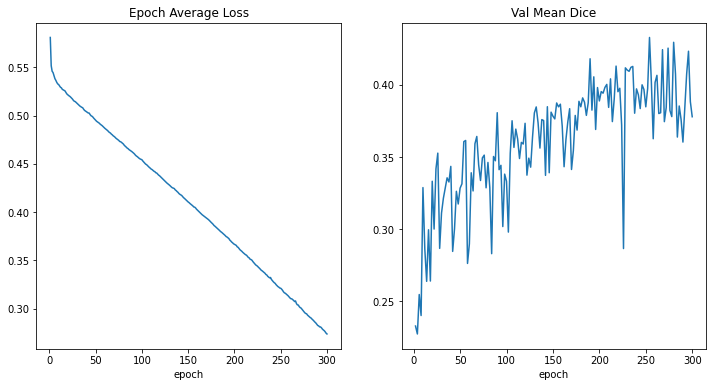

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

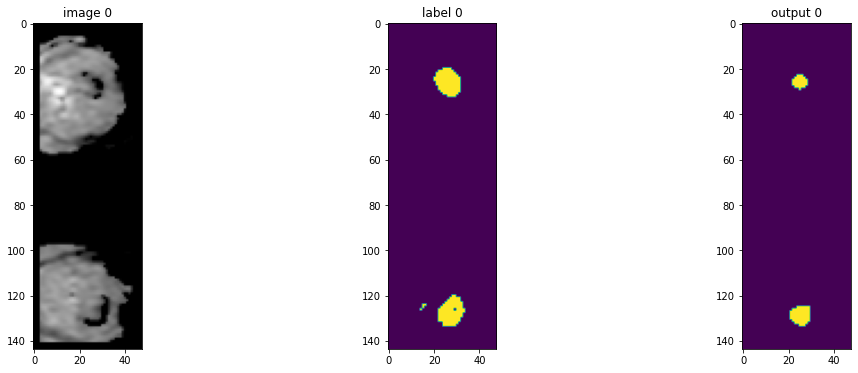

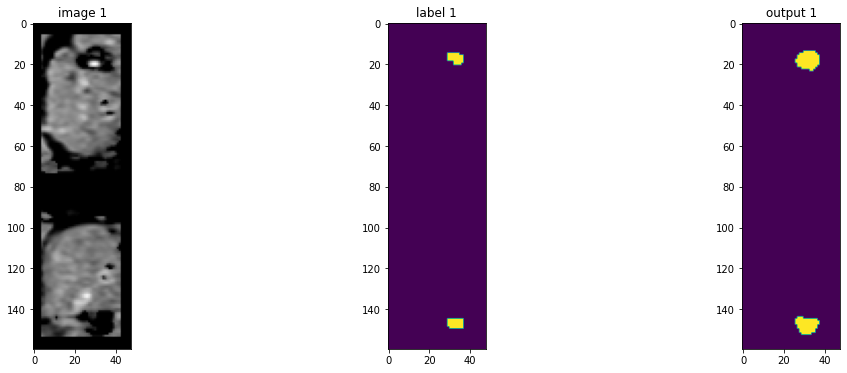

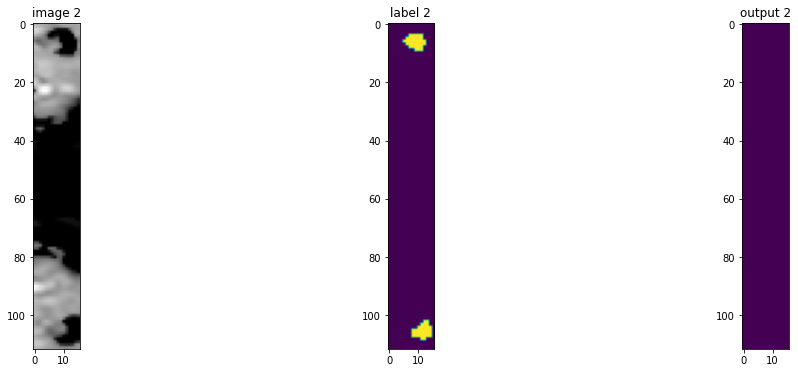

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 60], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 60])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 60])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            2, 2, 2), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        DivisiblePadd(["image", "label"], 16),

    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys=["pred","label"],
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys=["pred_meta_dict", "label_meta_dict"],
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
        device="cpu",
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.33623823523521423


## Inference on Test Set

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[0][:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)